# Section A : Data Import and Pre-Processing
    
   ## A.1 Import and install dependencies

In [452]:
import pandas as pd
import numpy as np
import os
! pip install geocoder
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib as mpl 
import seaborn as sns
import matplotlib.pyplot as plt
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


## A.2 Read datasets and pre-process
### A.2.1 Read apartment_data.csv and build a dataframe(bang_apt) for apartment name, latitude and longitude

In [453]:
bang_apt=pd.read_csv(r'C:\Users\araga\Documents\GitHub\DataBank\datasets_151373_358770_apartment_data.csv')
bang_apt=bang_apt.dropna()
bang_apt.drop(['geometry'],axis=1,inplace=True)
bang_apt[['names','city']] = bang_apt['names'].str.split('bangalore',expand=True)
bang_apt.drop(['city'],axis=1,inplace=True)
bang_apt=bang_apt.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
bang_apt

names        lat        lon
0                  Purva Skydale  12.894033  77.662362
1      Salarpuria Sattva Cadenza  12.889441  77.640221
2                Shriram Summitt  12.836068  77.667242
3                  Shriram Luxor  13.085249  77.654915
4     Ecolife Elements Of Nature  12.938728  77.731126
...                          ...        ...        ...
1119                 Maa Nivasam  12.998921  77.722856
1120              Desai Grandeur  12.976704  77.758471
1121            Soma White House  12.875321  77.635519
1122        Sunland Serene Hills  12.796947  77.531457
1123             CMRS Palm Hills  13.352676  77.722192

[1124 rows x 3 columns]

### A.2.2 Read  apartment_details.csv and build a dataframe(bang_apt_det) by pre-processing data

In [454]:
import re
bang_apt_details=pd.read_csv(r'C:\Users\araga\Documents\GitHub\DataBank\datasets_151373_358770_blore_apartment_data.csv')
bang_apt_details=bang_apt_details.dropna()
bang_apt_details[['Price-L','Price-H']] = bang_apt_details['Price'].str.split('-',expand=True)
bang_apt_details[['Area','Unit']] = bang_apt_details['Area'].str.split('s',expand=True)
bang_apt_details[['Size(BHK)','BHK']] = bang_apt_details['Unit Type'].str.split('B',expand=True)
bang_apt_details.drop(['BHK','Unit Type'],axis=1,inplace=True)
bang_apt_details.drop(['Price'],axis=1,inplace=True)
bang_apt_details.drop(['Unit'],axis=1,inplace=True)
bang_apt_details[['Area-L','Area-H']] = bang_apt_details['Area'].str.split('-',expand=True)
bang_apt_details.drop(['Area'],axis=1,inplace=True)
bang_apt_details['Price-H']=np.where(bang_apt_details['Price-H'].isnull(),bang_apt_details['Price-L'],bang_apt_details['Price-H'])
bang_apt_details['Area-H']=np.where(bang_apt_details['Area-H'].isnull(),bang_apt_details['Area-L'],bang_apt_details['Area-H'])
bang_apt_details['Price-L-num']=bang_apt_details['Price-L'].str.extract('(\d*\.\d+|\d+)').astype(float)
bang_apt_details['Price-H-num']=bang_apt_details['Price-H'].str.extract('(\d*\.\d+|\d+)').astype(float)
bang_apt_details.loc[bang_apt_details['Price-L'].str.contains('L'),'Price-L-num']*=100000
bang_apt_details.loc[bang_apt_details['Price-L'].str.contains('C'),'Price-L-num']*=10000000
bang_apt_details.loc[bang_apt_details['Price-H'].str.contains('L'),'Price-H-num']*=100000
bang_apt_details.loc[bang_apt_details['Price-H'].str.contains('C'),'Price-H-num']*=10000000
bang_apt_details=bang_apt_details.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
bang_apt_details.drop(['Price-L','Price-H'],axis=1,inplace=True)
bang_apt_details['Size(BHK)'] = bang_apt_details['Size(BHK)'].replace({'4+':'4.5'})
bang_apt_details['Size(BHK)'] = bang_apt_details['Size(BHK)'].replace({'1 RK StudioApartment':'0.5'})
bang_apt_details['Size(BHK)'] = bang_apt_details['Size(BHK)'].replace({'1 RK Apartment':'0.5'})
bang_apt_details['Size(BHK)'] = bang_apt_details['Size(BHK)'].replace({'1 RK':'0.5'})
bang_apt_details['Size(BHK)'] = bang_apt_details['Size(BHK)'].replace({'Studio':'0.5'})
bang_apt_details['Size(BHK)'] = bang_apt_details['Size(BHK)'].replace({'Apartment':'2'})
bang_apt_details=bang_apt_details[~bang_apt_details['Size(BHK)'].str.contains('Plot')]
bang_apt_details['Size(BHK)'] = bang_apt_details['Size(BHK)'].astype(float)
bang_apt_details['Area-L'] = bang_apt_details['Area-L'].astype(float)
bang_apt_details['Area-H'] = bang_apt_details['Area-H'].astype(float)
bang_apt_details

names  Size(BHK)  Area-L  Area-H  Price-L-num  \
0     Salarpuria Sattva Cadenza        1.0   755.0   755.0    3900000.0   
1     Salarpuria Sattva Cadenza        2.0  1175.0  1275.0    5500000.0   
2     Salarpuria Sattva Cadenza        2.5  1335.0  1340.0    7004000.0   
3     Salarpuria Sattva Cadenza        3.0  1365.0  1595.0    6500000.0   
4                 Purva Skydale        2.0  1273.0  1371.0    7625000.0   
...                         ...        ...     ...     ...          ...   
2655                 Sobha Onyx        3.0  1822.0  1946.0   11200000.0   
2656                 Sobha Onyx        3.0  2612.0  2612.0   16400000.0   
2657                 Sobha Onyx        4.0  3670.0  3670.0   23100000.0   
2658                Aban Desire        2.0   954.0  1162.0    5998000.0   
2659                Aban Desire        3.0  1266.0  1901.0    5998000.0   

      Price-H-num  
0       4165000.0  
1       7500000.0  
2       7330000.0  
3       9500000.0  
4      17500000.0  
...           ...  
2655   16000000.0  
2656   16400000.0  
2657   23100000.0  
2658    7233000.0  
2659   11600000.0  

[2378 rows x 6 columns]

### A.2.3 Merge the datasets bang_apt, bang_apt_details to create a global dataset bang_fin

In [455]:
bang_fin=pd.merge(bang_apt,bang_apt_details,on=['names'])
bang_fin['Price-L-num'] = bang_fin.apply(lambda x: x['Price-H-num'] if x['Price-L-num']==0 else x['Price-L-num'], axis=1)
bang_fin

names        lat        lon  Size(BHK)  Area-L  \
0                 Purva Skydale  12.894033  77.662362        2.0  1273.0   
1                 Purva Skydale  12.894033  77.662362        3.0  1625.0   
2     Salarpuria Sattva Cadenza  12.889441  77.640221        1.0   755.0   
3     Salarpuria Sattva Cadenza  12.889441  77.640221        2.0  1175.0   
4     Salarpuria Sattva Cadenza  12.889441  77.640221        2.5  1335.0   
...                         ...        ...        ...        ...     ...   
2315             Raynal Gardens  12.976732  77.514871        3.0  1571.0   
2316   Sobha City Casa Serenita  13.076939  77.639448        2.0  1305.0   
2317   Sobha City Casa Serenita  13.076939  77.639448        3.0  1705.0   
2318                   SK Daisy  12.832197  77.648919        2.0  1093.0   
2319                   SK Daisy  12.832197  77.648919        3.0  1166.0   

      Area-H  Price-L-num  Price-H-num  
0     1371.0    7625000.0   17500000.0  
1     1929.0    9300000.0   15800000.0  
2      755.0    3900000.0    4165000.0  
3     1275.0    5500000.0    7500000.0  
4     1340.0    7004000.0    7330000.0  
...      ...          ...          ...  
2315  1615.0    9900000.0    9900000.0  
2316  1445.0    6500000.0    7197000.0  
2317  1705.0    7200000.0    9300000.0  
2318  1107.0    3825000.0    3874000.0  
2319  1453.0    4081000.0    5585000.0  

[2320 rows x 8 columns]

## A.3 Visualize the global list of apartments in the bangalore city
### A.3.1 Fetch the Geolocations of Bangalore city from geocodes package

In [456]:
address = 'Bangalore,KA,India'
geolocator=Nominatim(user_agent="Bangalore Explorer")
location=geolocator.geocode(address) 
bg_latitude=location.latitude
bg_longitude=location.longitude
print('The geograpical coordinates of Bangalore City are {}, {}.'.format(bg_latitude,bg_longitude))

The geograpical coordinates of Bangalore City are 12.9791198, 77.5912997.


### A.3.2 Visualize the apartments on the bangalore city map

In [457]:
map_bangalore=folium.Map(location=[bg_latitude,bg_longitude],zoom_start=12)

for lat,long,apartment in zip(bang_fin['lat'],bang_fin['lon'],bang_fin['names']):
    label='{}'.format(apartment)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_bangalore)
    
map_bangalore

## A.4 Building a dataset for only 3 BHKs and visualizing them
### A.4.1 Building a dataset for 3 BHKs out of the global bangalore dataset

In [458]:
pd.options.mode.chained_assignment = None
df_surya=bang_fin[(bang_fin['Size(BHK)']) == 3.0]
df_surya['Average-area']=df_surya[['Area-L','Area-H']].mean(axis=1)
df_surya['Average-price']=df_surya[['Price-L-num','Price-H-num']].mean(axis=1)
df_surya.drop(['Area-L','Area-H','Price-L-num','Price-H-num'],axis=1,inplace=True)
df_surya.drop_duplicates(subset='names',keep=False,inplace=True)
df_surya.reset_index(inplace=True,drop=True)
df_surya.to_csv('df_surya.csv')
df_surya

names        lat        lon  Size(BHK)  \
0                     Purva Skydale  12.894033  77.662362        3.0   
1         Salarpuria Sattva Cadenza  12.889441  77.640221        3.0   
2                   Shriram Summitt  12.836068  77.667242        3.0   
3                     Shriram Luxor  13.085249  77.654915        3.0   
4        Ecolife Elements Of Nature  12.938728  77.731126        3.0   
..                              ...        ...        ...        ...   
622                   Vestaa Lushes  12.849659  77.734746        3.0   
623  Bhartiya City Leela Residences  13.084283  77.642781        3.0   
624                  Raynal Gardens  12.976732  77.514871        3.0   
625        Sobha City Casa Serenita  13.076939  77.639448        3.0   
626                        SK Daisy  12.832197  77.648919        3.0   

     Average-area  Average-price  
0          1777.0     12550000.0  
1          1480.0      8000000.0  
2          1707.0     10900000.0  
3          1550.0      9028000.0  
4          1490.0      8050000.0  
..            ...            ...  
622        1435.0      3157000.0  
623        3122.5     35850000.0  
624        1593.0      9900000.0  
625        1705.0      8250000.0  
626        1309.5      4833000.0  

[627 rows x 6 columns]

### A.4.2 Visualizing the 3 BHKs on the Map

In [459]:
map_bangalore=folium.Map(location=[bg_latitude,bg_longitude],zoom_start=12)

for lat,long,apartment in zip(df_surya['lat'],df_surya['lon'],df_surya['names']):
    label='{}'.format(apartment)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='green',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_bangalore)
    
map_bangalore

## A.5 Exploratory Data Analysis
### A.5.1 Building an exploration data set

In [460]:
pd.options.mode.chained_assignment = None
bg_explore=bang_fin.copy()
bg_explore['Average-area']=bg_explore[['Area-L','Area-H']].mean(axis=1)
bg_explore['Average-price']=bg_explore[['Price-L-num','Price-H-num']].mean(axis=1)
bg_explore[['Builder','Apart']] = bg_explore['names'].str.split(n=1,expand=True)
bg_explore.drop(['Area-L','Area-H','Price-L-num','Price-H-num','Apart'],axis=1,inplace=True)
bg_explore.reset_index(inplace=True,drop=True)
bg_explore

names        lat        lon  Size(BHK)  \
0                 Purva Skydale  12.894033  77.662362        2.0   
1                 Purva Skydale  12.894033  77.662362        3.0   
2     Salarpuria Sattva Cadenza  12.889441  77.640221        1.0   
3     Salarpuria Sattva Cadenza  12.889441  77.640221        2.0   
4     Salarpuria Sattva Cadenza  12.889441  77.640221        2.5   
...                         ...        ...        ...        ...   
2315             Raynal Gardens  12.976732  77.514871        3.0   
2316   Sobha City Casa Serenita  13.076939  77.639448        2.0   
2317   Sobha City Casa Serenita  13.076939  77.639448        3.0   
2318                   SK Daisy  12.832197  77.648919        2.0   
2319                   SK Daisy  12.832197  77.648919        3.0   

      Average-area  Average-price     Builder  
0           1322.0     12562500.0       Purva  
1           1777.0     12550000.0       Purva  
2            755.0      4032500.0  Salarpuria  
3           1225.0      6500000.0  Salarpuria  
4           1337.5      7167000.0  Salarpuria  
...            ...            ...         ...  
2315        1593.0      9900000.0      Raynal  
2316        1375.0      6848500.0       Sobha  
2317        1705.0      8250000.0       Sobha  
2318        1100.0      3849500.0          SK  
2319        1309.5      4833000.0          SK  

[2320 rows x 7 columns]

### A.5.2 Lets count the number of apartments for each size

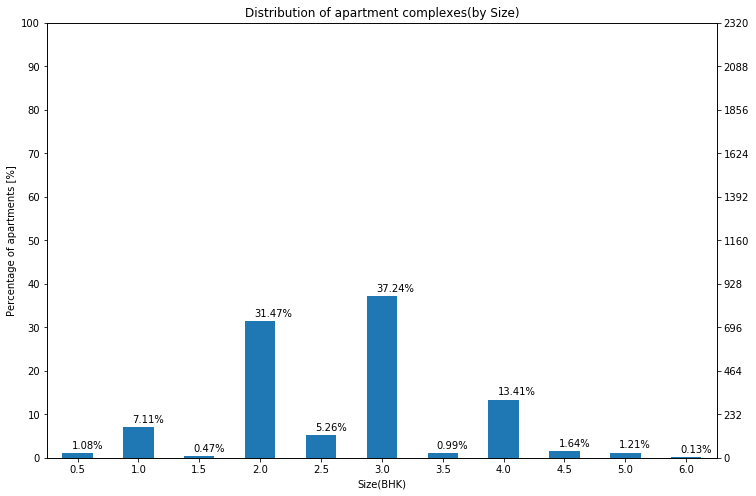

In [461]:
plt.figure(figsize=(12,8))
plt.title('Distribution of apartment complexes(by Size)')
plt.xlabel('Size(BHK)')
plt.ylabel('Percentage of apartments [%]')

ax = (bg_explore['Size(BHK)'].value_counts()/len(bg_explore)*100).sort_index().plot(kind="bar", rot=0)
ax.set_yticks(np.arange(0, 110, 10))

ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(bg_explore)/100)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.savefig("apartment_distribution.png")

### A.5.3 Lets understand the relationship between Price and Area for various apartment sizes

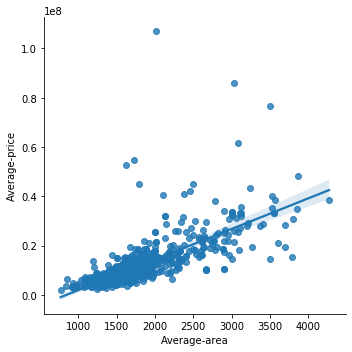

In [462]:
sns.lmplot(data=bg_explore[bg_explore['Size(BHK)']==3],x="Average-area",y="Average-price",fit_reg=True)
plt.savefig('area_price_lm.png')

# Section B: Building Venue Information to the base dataset
## B.1 Calling Foursquare for one venue to analyze data structure
### B.1.1 Creating credentials for foursquare call

In [463]:
CLIENT_ID = 'CED4RQMWZBS0WYLEZ2O5W14SF3X4ZMUHF2B3Z25DRTWTU4VC' # your Foursquare ID
CLIENT_SECRET = 'YKFZYNQF43KRE1UFZY4QYVNKIKBBR2WODPI2U1PLCDDW31IO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CED4RQMWZBS0WYLEZ2O5W14SF3X4ZMUHF2B3Z25DRTWTU4VC
CLIENT_SECRET:YKFZYNQF43KRE1UFZY4QYVNKIKBBR2WODPI2U1PLCDDW31IO


### B.1.2 Calling Foursquare using latitude and longitude for one apartment

In [464]:
bdg=df_surya.loc[13,'names']
bdg_lat=df_surya.loc[13,'lat']
bdg_long=df_surya.loc[13,'lon']
print('The Apartment of {}, has latitude {}, Longitude {}'.format(bdg,bdg_lat,bdg_long))

The Apartment of Bren Imperia, has latitude 12.9068814, Longitude 77.671808


In [465]:
radius=2000
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, bdg_lat, bdg_long, VERSION, radius, LIMIT,'HOSPITALS')
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee5f5f8867c843e1ae74315'},
 'response': {'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'query': 'hospitals',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 12.924881418000018,
    'lng': 77.69024010866829},
   'sw': {'lat': 12.888881381999981, 'lng': 77.6533758913317}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54abdf8a498ed225673ecb82',
       'name': 'Motherhood Hospitals',
       'location': {'lat': 12.917645775635862,
        'lng': 77.67229771465814,
        'labeledLatLngs': [{'label': 'display',
          'lat': 12.917645775635862,
          'lng': 77.67229771465814}],
        'distance': 1199,
        'cc': 'IN',
        'country':

## B.2 Calling FourSquare to get Venue information in 2 Kms for all building
### B.2.1 Writing a function to get the venues from Foursquare for all location and save it in a dataset

In [473]:
import time
def getNearbyVenues(names,latitudes,longitudes,sizes,areas,prices,radius=5000):
    venues_list=[]
    i=0
    for name, lat, lng,size,area,price in zip(names, latitudes, longitudes,sizes,areas,prices):
        # create the API request URL
        print(i,name)
        callsucc=0
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
         # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            venues_list.append([(
            name, 
            lat, 
            lng,
            size,
            area,
            price,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Apt Name', 
                  'Apt Latitude', 
                  'Apt Longitude', 
                  'Apt Size(BHK)',
                  'Apt Area(sq ft)', 
                  'Apt Price(INR)'
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        except:
            time.sleep(1)
            continue
            
            
            
        # return only relevant information for each nearby venue
      
        i=i+1
    return(nearby_venues)

### B.2.2 Calling the Function written above for the Dataset in question

In [474]:
df_venues= getNearbyVenues(names=df_surya['names'],latitudes=df_surya['lat'],
                           longitudes=df_surya['lon'],
                           sizes=df_surya['Size(BHK)'],areas=df_surya['Average-area'],
                            prices=df_surya['Average-price'])
 

0 Purva Skydale
0 Salarpuria Sattva Cadenza
0 Shriram Summitt
0 Shriram Luxor
0 Ecolife Elements Of Nature
0 Salarpuria Sattva East Crest
0 Shriram Greenfield Phase 1
0 Century Infiniti
0 Vaswani Exquisite
0 Vaishnavi Gardenia
0 Bren Edgewaters
0 DSMAX SAROVAR
0 Niranjan Tridha
0 Bren Imperia
0 Nandi Citadel
0 Sobha Avenue
0 Provident Sunworth
0 Purva Northern Waves
0 Prestige Falcon City
0 Mahaveer Ranches
0 SNN Raj Etternia
0 Karsten Palm Groves
0 Salarpuria Sattva Celesta
0 DSMAX SKYCITY
0 Meda Greens
0 Phoenix One Bangalore West
0 Salarpuria Sattva Greenage Phase II
0 Candeur Carlisle
0 Arya Hamsa Grande
0 Purva Palm Beach
0 Prestige Song Of The South
0 Salarpuria Sattva Laurel Heights
0 Sumo Sonnet
0 Kritan Ira
0 MDVR Byrathi Residency
0 Candeur Landmark
0 Sterling Ascentia
0 Vaishnavi Terraces
0 PSR Krish Kamal
0 Hiren High Cliff
0 JR Nexus
0 Mahendra Aarna
0 Mittal Elanza
0 Mantri Energia
0 Prestige Misty Waters phase 1
0 Sobha Heritage
0 The County Address
0 Rohan Akriti
0 Sala

0 KMB La Palazzo
0 Karle Zenith Residences
0 Prestige Ferns Residency
0 Hiranandani Club Meadows
0 Vaishnavi Nakshatra
0 VMAKS Heights
0 BSR Sunshine
0 Sobha Ruby
0 Sobha Valley View
0 Canary Woods
0 Hiranandani Glen Gate
0 Sobha Clovelly
0 Prestige Lakeside Habitat Villa
0 Dharma Elite
0 Jain Heights East Parade
0 Sobha Daisy
0 Provident Harmony
0 Hrvy Sai Sapphire
0 Vishwapriya Vertical Garden
0 Opera Canopus
0 Sipani Jardin
0 Sobha Indraprastha
0 Pyramid Carnations
0 L&T South City
0 Buildmann Aaroha Condominiums
0 Svamitva Emerald Square
0 RJ Brooke Square
0 Balaji Ashirvaad Elite
0 Hiranandani Horizon
0 Corporate Suncity Gloria Block B
0 Prisha Orchids
0 SSVR Fairy Bells
0 United Meadows
0 Purva Waves
0 Habitat Eden Heights
0 Habitat Iluminar
0 Pruthvi Royal
0 Godrej Gold County
0 Brigade Millennium
0 TG Ascent
0 Mahaveer Promenade
0 Aratt Cityscapes Apartment
0 Radiant Elitaire
0 RNS Shrinikethan
0 Prestige Gulmohar
0 DNR Atmosphere
0 Shell North Gate
0 MJ Lifestyle Astro
0 Sowpa

## B.3 Building the Output Dataset from the Foursquare API and checking information 
### B.3.1 Building the base dataset

In [481]:
df_venues.columns = ['Apt Name', 
                  'Apt Latitude', 
                  'Apt Longitude', 
                  'Apt Size(BHK)',
                  'Apt Area(sq ft)', 
                  'Apt Price(INR)',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
df_venues=df_venues.dropna()
df_venues.to_csv('venues.csv')
df_venues

Apt Name  Apt Latitude  Apt Longitude  Apt Size(BHK)  \
0      Purva Skydale     12.894033      77.662362            3.0   
1      Purva Skydale     12.894033      77.662362            3.0   
2      Purva Skydale     12.894033      77.662362            3.0   
3      Purva Skydale     12.894033      77.662362            3.0   
4      Purva Skydale     12.894033      77.662362            3.0   
...              ...           ...            ...            ...   
39146       SK Daisy     12.832197      77.648919            3.0   
39147       SK Daisy     12.832197      77.648919            3.0   
39148       SK Daisy     12.832197      77.648919            3.0   
39149       SK Daisy     12.832197      77.648919            3.0   
39150       SK Daisy     12.832197      77.648919            3.0   

       Apt Area(sq ft)  Apt Price(INR)                    Venue  \
0               1777.0      12550000.0             Corner House   
1               1777.0      12550000.0               Play Arena   
2               1777.0      12550000.0                    Kanua   
3               1777.0      12550000.0        Natural Ice Cream   
4               1777.0      12550000.0              Big Brewsky   
...                ...             ...                      ...   
39146           1309.5       4833000.0     Sourcebits Cafeteria   
39147           1309.5       4833000.0  Infosys Football Ground   
39148           1309.5       4833000.0              Huskur Gate   
39149           1309.5       4833000.0                    E inn   
39150           1309.5       4833000.0         HCL Technologies   

       Venue Latitude  Venue Longitude         Venue Category  
0           12.909949        77.651883         Ice Cream Shop  
1           12.911591        77.676169  General Entertainment  
2           12.908984        77.680702      Indian Restaurant  
3           12.912803        77.680232         Ice Cream Shop  
4           12.913141        77.683233                Brewery  
...               ...              ...                    ...  
39146       12.851377        77.658698             Food Court  
39147       12.850082        77.661574           Soccer Field  
39148       12.839797        77.677198               Bus Stop  
39149       12.823991        77.681168      Indian Restaurant  
39150       12.787408        77.651641           Tech Startup  

[39151 rows x 10 columns]

### B.3.2 Check the venues received for each apartment

In [484]:
df_venues.groupby('Apt Name').count()

Apt Latitude  Apt Longitude  Apt Size(BHK)  \
Apt Name                                                           
42 Queens Square                 5              5              5   
A Peace Paramount               27             27             27   
ARS Bhavisha                     5              5              5   
Aakruthi Aura                  100            100            100   
Aashrayaa Eternia              100            100            100   
...                            ...            ...            ...   
Vriksha by Provident             7              7              7   
Whitestone Rosario             100            100            100   
Yuva Eka                        81             81             81   
Zed Earth                      100            100            100   
Zonasha Paradiso               100            100            100   

                      Apt Area(sq ft)  Apt Price(INR)  Venue  Venue Latitude  \
Apt Name                                                                       
42 Queens Square                    5               5      5               5   
A Peace Paramount                  27              27     27              27   
ARS Bhavisha                        5               5      5               5   
Aakruthi Aura                     100             100    100             100   
Aashrayaa Eternia                 100             100    100             100   
...                               ...             ...    ...             ...   
Vriksha by Provident                7               7      7               7   
Whitestone Rosario                100             100    100             100   
Yuva Eka                           81              81     81              81   
Zed Earth                         100             100    100             100   
Zonasha Paradiso                  100             100    100             100   

                      Venue Longitude  Venue Category  
Apt Name                                               
42 Queens Square                    5               5  
A Peace Paramount                  27              27  
ARS Bhavisha                        5               5  
Aakruthi Aura                     100             100  
Aashrayaa Eternia                 100             100  
...                               ...             ...  
Vriksha by Provident                7               7  
Whitestone Rosario                100             100  
Yuva Eka                           81              81  
Zed Earth                         100             100  
Zonasha Paradiso                  100             100  

[617 rows x 9 columns]

### B.3.3 Checking the venues received for each category

In [487]:
df_venueg=df_venues.groupby('Venue Category').count()
df_venueg.drop(['Apt Name','Apt Latitude','Apt Longitude','Apt Size(BHK)','Apt Area(sq ft)','Apt Price(INR)','Venue Latitude','Venue Longitude'],axis=1,inplace=True)
df_venueg.rename(columns={'Venue':'Venue_count'},inplace=True)
df_venueg.sort_values(['Venue_count'],ascending=False,inplace=True)
df_venueg.to_csv("Venue_impact.csv")
df_venueg

Venue_count
Venue Category                
Indian Restaurant         4557
Café                      2944
Ice Cream Shop            2191
Pizza Place               2063
Hotel                     1620
...                        ...
Business Service             1
Event Space                  1
Campground                   1
Sculpture Garden             1
Organic Grocery              1

[231 rows x 1 columns]

# Section C: Analyzing Apartments to Identify top Venues
## C.1  One Hot encoding the data set by venue categories and group them by apartment 
### C.1.1 One Hot encode all the venue categories

In [488]:
bg_onehot=pd.get_dummies(df_venues[['Venue Category']],prefix="",prefix_sep="")
apt=df_venues['Apt Name']
area=df_venues['Apt Area(sq ft)']
price=df_venues['Apt Price(INR)']
bg_onehot.insert(0,'Price',price)
bg_onehot.insert(0,'Area',area)
bg_onehot.insert(0,'Apartment',apt)
print(bg_onehot.shape)
bg_onehot.head()

(39151, 234)


Apartment    Area       Price  ATM  Afghan Restaurant  Airport  \
0  Purva Skydale  1777.0  12550000.0    0                  0        0   
1  Purva Skydale  1777.0  12550000.0    0                  0        0   
2  Purva Skydale  1777.0  12550000.0    0                  0        0   
3  Purva Skydale  1777.0  12550000.0    0                  0        0   
4  Purva Skydale  1777.0  12550000.0    0                  0        0   

   Airport Service  Airport Terminal  American Restaurant  Andhra Restaurant  \
0                0                 0                    0                  0   
1                0                 0                    0                  0   
2                0                 0                    0                  0   
3                0                 0                    0                  0   
4                0                 0                    0                  0   

   ...  Udupi Restaurant  Vegetarian / Vegan Restaurant  \
0  ...                 0                              0   
1  ...                 0                              0   
2  ...                 0                              0   
3  ...                 0                              0   
4  ...                 0                              0   

   Vietnamese Restaurant  Vineyard  Warehouse Store  Watch Shop  Wine Bar  \
0                      0         0                0           0         0   
1                      0         0                0           0         0   
2                      0         0                0           0         0   
3                      0         0                0           0         0   
4                      0         0                0           0         0   

   Wine Shop  Women's Store  Yoga Studio  
0          0              0            0  
1          0              0            0  
2          0              0            0  
3          0              0            0  
4          0              0            0  

[5 rows x 234 columns]

### C.1.2 Group the dataset by Apartment Name

In [489]:
bg_grouped=bg_onehot.groupby('Apartment').mean().reset_index()
bg_grouped

Apartment    Area       Price  ATM  Afghan Restaurant  \
0        42 Queens Square  1930.5  11700000.0  0.0               0.00   
1       A Peace Paramount  1447.5   5498500.0  0.0               0.00   
2            ARS Bhavisha  1548.0   7511000.0  0.0               0.00   
3           Aakruthi Aura  1450.0   4600000.0  0.0               0.00   
4       Aashrayaa Eternia  1679.0  11350000.0  0.0               0.00   
..                    ...     ...         ...  ...                ...   
612  Vriksha by Provident  1187.0   6728500.0  0.0               0.00   
613    Whitestone Rosario  1254.0   4578000.0  0.0               0.00   
614              Yuva Eka  1438.5   6183500.0  0.0               0.00   
615             Zed Earth  3028.0  25750000.0  0.0               0.01   
616      Zonasha Paradiso  2122.0  14550000.0  0.0               0.00   

      Airport  Airport Service  Airport Terminal  American Restaurant  \
0    0.000000              0.0               0.0             0.000000   
1    0.037037              0.0               0.0             0.037037   
2    0.000000              0.0               0.0             0.000000   
3    0.000000              0.0               0.0             0.020000   
4    0.000000              0.0               0.0             0.020000   
..        ...              ...               ...                  ...   
612  0.000000              0.0               0.0             0.000000   
613  0.000000              0.0               0.0             0.020000   
614  0.000000              0.0               0.0             0.012346   
615  0.000000              0.0               0.0             0.010000   
616  0.000000              0.0               0.0             0.030000   

     Andhra Restaurant  ...  Udupi Restaurant  Vegetarian / Vegan Restaurant  \
0                 0.00  ...               0.0                           0.00   
1                 0.00  ...               0.0                           0.00   
2                 0.00  ...               0.0                           0.00   
3                 0.00  ...               0.0                           0.01   
4                 0.01  ...               0.0                           0.02   
..                 ...  ...               ...                            ...   
612               0.00  ...               0.0                           0.00   
613               0.00  ...               0.0                           0.01   
614               0.00  ...               0.0                           0.00   
615               0.00  ...               0.0                           0.00   
616               0.01  ...               0.0                           0.00   

     Vietnamese Restaurant  Vineyard  Warehouse Store  Watch Shop  Wine Bar  \
0                      0.0       0.0              0.0         0.0       0.0   
1                      0.0       0.0              0.0         0.0       0.0   
2                      0.0       0.0              0.0         0.0       0.0   
3                      0.0       0.0              0.0         0.0       0.0   
4                      0.0       0.0              0.0         0.0       0.0   
..                     ...       ...              ...         ...       ...   
612                    0.0       0.0              0.0         0.0       0.0   
613                    0.0       0.0              0.0         0.0       0.0   
614                    0.0       0.0              0.0         0.0       0.0   
615                    0.0       0.0              0.0         0.0       0.0   
616                    0.0       0.0              0.0         0.0       0.0   

     Wine Shop  Women's Store  Yoga Studio  
0          0.0           0.00          0.0  
1          0.0           0.00          0.0  
2          0.0           0.00          0.0  
3          0.0           0.00          0.0  
4          0.0           0.00          0.0  
..         ...            ...          ...  
612        0.0           0.00        

## C.2 Identifying top 5 venues near each apartment

In [490]:
num_top_venues = 5

for apt in bg_grouped['Apartment']:
    print("----"+apt+"----")
    temp = bg_grouped[bg_grouped['Apartment'] == apt].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[3:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----42 Queens Square----
                  venue  freq
0           Golf Course   0.4
1              Pharmacy   0.2
2  Fast Food Restaurant   0.2
3              Bus Stop   0.2
4          Noodle House   0.0


----A Peace Paramount----
               venue  freq
0  Indian Restaurant  0.26
1               Café  0.19
2   Basketball Court  0.04
3              Hotel  0.04
4         Smoke Shop  0.04


----ARS Bhavisha----
                  venue  freq
0           Flower Shop   0.2
1  Fast Food Restaurant   0.2
2              Bus Stop   0.2
3        Lighting Store   0.2
4         Go Kart Track   0.2


----Aakruthi Aura----
               venue  freq
0               Café  0.10
1  Indian Restaurant  0.09
2         Restaurant  0.08
3              Hotel  0.07
4        Pizza Place  0.06


----Aashrayaa Eternia----
               venue  freq
0  Indian Restaurant  0.12
1               Café  0.10
2     Ice Cream Shop  0.09
3   Department Store  0.05
4        Pizza Place  0.04


----Adarsh Citrine----
 

                  venue  freq
0           Pizza Place  0.13
1     Indian Restaurant  0.11
2                  Café  0.10
3  Fast Food Restaurant  0.07
4                Bakery  0.05


----Brigade Altamont----
                venue  freq
0   Indian Restaurant  0.13
1         Pizza Place  0.09
2                Café  0.07
3           BBQ Joint  0.06
4  Chinese Restaurant  0.06


----Brigade Buena Vista Phase I----
                venue  freq
0          Toll Plaza   0.2
1          Restaurant   0.2
2         Supermarket   0.2
3      Shopping Plaza   0.2
4  Athletics & Sports   0.2


----Brigade Caladium----
                  venue  freq
0     Indian Restaurant  0.18
1        Ice Cream Shop  0.11
2           Pizza Place  0.11
3                  Café  0.08
4  Fast Food Restaurant  0.07


----Brigade Exotica - Azure Tower----
              venue  freq
0  Department Store  0.12
1       Supermarket  0.12
2  Asian Restaurant  0.06
3    Shopping Plaza  0.06
4              Café  0.06


----Brigade Ex

                  venue  freq
0     Indian Restaurant  0.11
1                  Café  0.10
2  Fast Food Restaurant  0.06
3        Ice Cream Shop  0.06
4           Pizza Place  0.04


----Concorde Amber----
               venue  freq
0               Café  0.12
1        Pizza Place  0.10
2              Hotel  0.07
3        Coffee Shop  0.06
4  Indian Restaurant  0.06


----Concorde Luxepolis----
               venue  freq
0  Indian Restaurant  0.16
1     Ice Cream Shop  0.10
2              Hotel  0.05
3             Lounge  0.04
4             Bakery  0.04


----Concorde Napa Valley----
    venue  freq
0  Resort  0.18
1     Spa  0.09
2   Diner  0.09
3   Hotel  0.09
4    Café  0.09


----Concorde Spring Meadows----
                  venue  freq
0           Pizza Place  0.18
1  Fast Food Restaurant  0.12
2           Coffee Shop  0.12
3                 Plaza  0.06
4         Train Station  0.06


----Concorde Tech Turf----
                  venue  freq
0     Indian Restaurant  0.14
1           

4  Multiplex  0.00


----Gnana Bhoomi----
                  venue  freq
0            Playground  0.25
1              Vineyard  0.25
2  Fast Food Restaurant  0.25
3           Bus Station  0.25
4                   ATM  0.00


----Godrej E-City----
                  venue  freq
0                 Hotel  0.15
1     Indian Restaurant  0.13
2           Coffee Shop  0.11
3  Fast Food Restaurant  0.07
4      Department Store  0.07


----Godrej Eternity----
                           venue  freq
0              Indian Restaurant  0.20
1               Department Store  0.13
2                          Trail  0.13
3  Vegetarian / Vegan Restaurant  0.07
4        South Indian Restaurant  0.07


----Godrej Eternity Life Plus----
                           venue  freq
0              Indian Restaurant  0.20
1               Department Store  0.13
2                          Trail  0.13
3  Vegetarian / Vegan Restaurant  0.07
4        South Indian Restaurant  0.07


----Godrej Gold County----
               

               venue  freq
0  Indian Restaurant  0.15
1               Café  0.13
2        Pizza Place  0.10
3             Bakery  0.08
4        Coffee Shop  0.05


----MBR Suave----
               venue  freq
0              Hotel  0.10
1               Café  0.10
2         Restaurant  0.09
3  Indian Restaurant  0.06
4            Brewery  0.06


----MDVR Byrathi Residency----
               venue  freq
0  Indian Restaurant  0.16
1        Pizza Place  0.08
2  Korean Restaurant  0.05
3          BBQ Joint  0.05
4               Café  0.05


----MJ Lifestyle Astro----
               venue  freq
0              Hotel  0.17
1        Coffee Shop  0.10
2               Café  0.10
3  Indian Restaurant  0.07
4         Food Court  0.07


----MN Guru Gokulam----
                venue  freq
0                Café  0.14
1   Indian Restaurant  0.09
2      Sandwich Place  0.06
3         Pizza Place  0.06
4  Chinese Restaurant  0.06


----MS Royal Sunnyvale----
                  venue  freq
0            Toll

4                 Hotel  0.04


----Pioneer KRS Park Royal----
               venue  freq
0               Café  0.16
1        Pizza Place  0.14
2  Indian Restaurant  0.12
3     Sandwich Place  0.07
4             Bakery  0.07


----Pioneer Kingstown----
                venue  freq
0   Indian Restaurant  0.14
1      Ice Cream Shop  0.10
2                Café  0.07
3         Pizza Place  0.05
4  Italian Restaurant  0.03


----Pioneer Park Avenue----
                venue  freq
0   Indian Restaurant  0.17
1    Department Store  0.07
2                Café  0.07
3         Pizza Place  0.04
4  Chinese Restaurant  0.04


----Pioneer Sun Blossom----
                  venue  freq
0     Indian Restaurant  0.14
1                 Hotel  0.14
2           Coffee Shop  0.10
3                  Café  0.08
4  Fast Food Restaurant  0.08


----Pionier Lifestyle----
               venue  freq
0               Café  0.10
1        Coffee Shop  0.10
2         Food Court  0.08
3        Pizza Place  0.05
4  India

                 venue  freq
0                 Café  0.33
1    Indian Restaurant  0.22
2  American Restaurant  0.11
3        Train Station  0.11
4               Bakery  0.11


----RJ Brooke Square----
               venue  freq
0  Indian Restaurant  0.11
1         Restaurant  0.08
2              Hotel  0.06
3               Café  0.05
4            Brewery  0.04


----RJ Lake Gardenia----
                  venue  freq
0           Coffee Shop  0.10
1                  Café  0.08
2     Indian Restaurant  0.05
3                 Hotel  0.04
4  Fast Food Restaurant  0.04


----RJR Patel Residency----
               venue  freq
0  Indian Restaurant  0.14
1        Pizza Place  0.07
2               Café  0.07
3         Restaurant  0.07
4              Hotel  0.05


----RNS Shrinikethan----
                  venue  freq
0     Indian Restaurant  0.13
1        Ice Cream Shop  0.08
2  Fast Food Restaurant  0.06
3    Italian Restaurant  0.05
4           Pizza Place  0.04


----RS Sanchike----
         

4  Monument / Landmark  0.00


----Shriram Greenfield Phase 2----
                 venue  freq
0          Supermarket  0.25
1    Indian Restaurant  0.25
2   Athletics & Sports  0.25
3           Toll Plaza  0.25
4  Monument / Landmark  0.00


----Shriram Luxor----
               venue  freq
0        Pizza Place  0.15
1  Indian Restaurant  0.08
2      Grocery Store  0.08
3        Coffee Shop  0.08
4         Restaurant  0.08


----Shriram Sameeksha----
               venue  freq
0        Pizza Place  0.12
1               Café  0.12
2              Hotel  0.08
3        Coffee Shop  0.08
4  Indian Restaurant  0.08


----Shriram Signia----
                  venue  freq
0     Indian Restaurant  0.14
1                 Hotel  0.14
2           Coffee Shop  0.10
3                  Café  0.08
4  Fast Food Restaurant  0.08


----Shriram Suhaana----
               venue  freq
0  Indian Restaurant  0.20
1               Café  0.20
2       Dessert Shop  0.07
3      Train Station  0.07
4         Smoke Sh

                     venue  freq
0                   Bakery  0.14
1        Indian Restaurant  0.14
2                    Hotel  0.14
3                   Resort  0.14
4  North Indian Restaurant  0.14


----The County Address----
                  venue  freq
0            Hookah Bar  0.29
1            Hobby Shop  0.14
2      Department Store  0.14
3  Fast Food Restaurant  0.14
4                Bakery  0.14


----The Five Summit Address----
               venue  freq
0  Indian Restaurant  0.11
1               Café  0.08
2              Hotel  0.07
3         Restaurant  0.06
4            Brewery  0.05


----The Gran Carmen Address----
                  venue  freq
0           Pizza Place  0.12
1                  Café  0.09
2  Fast Food Restaurant  0.08
3        Ice Cream Shop  0.06
4           Coffee Shop  0.06


----The Manya Magna Ville----
               venue  freq
0              Hotel  0.15
1  Indian Restaurant  0.13
2        Coffee Shop  0.11
3   Department Store  0.08
4        Pizza P

## C.3 Finding top 50 venues near each apartment to cluster them
### C.3.1  Writing a function to sort top venues near the apartment

In [491]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### C.3.2 Fetching top venues near the apartment

In [492]:
num_top_venues=50

indicators = ['st', 'nd', 'rd']

columns=['Apartment','Area','Price']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most common venue'.format(ind+1,indicators[ind]))
    except:
         columns.append('{}th Most common venue'.format(ind+1))
                        
bg_venues_sorted=pd.DataFrame(columns=columns)
bg_venues_sorted['Apartment'] = bg_grouped['Apartment']
bg_venues_sorted['Area'] = bg_grouped['Area']
bg_venues_sorted['Price'] = bg_grouped['Price']

for ind in np.arange(bg_grouped.shape[0]):
    bg_venues_sorted.iloc[ind,3:]=return_most_common_venues(bg_grouped.iloc[ind,:],num_top_venues)

bg_venues_sorted.head()


Apartment    Area       Price 1st Most common venue  \
0   42 Queens Square  1930.5  11700000.0           Golf Course   
1  A Peace Paramount  1447.5   5498500.0     Indian Restaurant   
2       ARS Bhavisha  1548.0   7511000.0           Flower Shop   
3      Aakruthi Aura  1450.0   4600000.0                  Café   
4  Aashrayaa Eternia  1679.0  11350000.0     Indian Restaurant   

  2nd Most common venue 3rd Most common venue 4th Most common venue  \
0              Pharmacy  Fast Food Restaurant              Bus Stop   
1                  Café         Train Station                Resort   
2  Fast Food Restaurant        Lighting Store              Bus Stop   
3     Indian Restaurant            Restaurant                 Hotel   
4                  Café        Ice Cream Shop      Department Store   

  5th Most common venue        6th Most common venue 7th Most common venue  \
0           Yoga Studio  Eastern European Restaurant     Fish & Chips Shop   
1      Basketball Court                       Bakery        Clothing Store   
2         Go Kart Track            Electronics Store           Flea Market   
3           Pizza Place                      Brewery        Ice Cream Shop   
4           Pizza Place                    Multiplex    Italian Restaurant   

   ... 41th Most common venue 42th Most common venue 43th Most common venue  \
0  ...                    Gym          Grocery Store          Go Kart Track   
1  ...         History Museum       Henan Restaurant       Halal Restaurant   
2  ...   Gym / Fitness Center                    Gym          Grocery Store   
3  ...      French Restaurant    Dumpling Restaurant      German Restaurant   
4  ...                 Bakery      Andhra Restaurant            Beer Garden   

  44th Most common venue 45th Most common venue  46th Most common venue  \
0      German Restaurant  General Entertainment               Gastropub   
1               Gym Pool   Gym / Fitness Center           Grocery Store   
2            Golf Course  General Entertainment              Food Court   
3          Go Kart Track    Fried Chicken Joint             Flower Shop   
4            Supermarket                    Bar  Furniture / Home Store   

    47th Most common venue 48th Most common venue   49th Most common venue  \
0              Gas Station          Garden Center                   Garden   
1              Golf Course          Go Kart Track        German Restaurant   
2                Gastropub            Gas Station            Garden Center   
3            Garden Center       Doner Restaurant  Fruit & Vegetable Store   
4  South Indian Restaurant    Indie Movie Theater      Sporting Goods Shop   

    50th Most common venue  
0              Gaming Cafe  
1    General Entertainment  
2                   Garden  
3                 Dive Bar  
4  Fruit & Vegetable Store  

[5 rows x 53 columns]

# Section D: Clustering Data based on Price, Venue and Area
## D.1 Preparing Data for Clustering
### D.1.1 Building cluster raw data set by dropping the Apartment name from the grouped data

In [493]:
bg_cluster_data=bg_grouped.drop('Apartment',1)
bg_cluster_data

Area       Price  ATM  Afghan Restaurant   Airport  Airport Service  \
0    1930.5  11700000.0  0.0               0.00  0.000000              0.0   
1    1447.5   5498500.0  0.0               0.00  0.037037              0.0   
2    1548.0   7511000.0  0.0               0.00  0.000000              0.0   
3    1450.0   4600000.0  0.0               0.00  0.000000              0.0   
4    1679.0  11350000.0  0.0               0.00  0.000000              0.0   
..      ...         ...  ...                ...       ...              ...   
612  1187.0   6728500.0  0.0               0.00  0.000000              0.0   
613  1254.0   4578000.0  0.0               0.00  0.000000              0.0   
614  1438.5   6183500.0  0.0               0.00  0.000000              0.0   
615  3028.0  25750000.0  0.0               0.01  0.000000              0.0   
616  2122.0  14550000.0  0.0               0.00  0.000000              0.0   

     Airport Terminal  American Restaurant  Andhra Restaurant  Arcade  ...  \
0                 0.0             0.000000               0.00     0.0  ...   
1                 0.0             0.037037               0.00     0.0  ...   
2                 0.0             0.000000               0.00     0.0  ...   
3                 0.0             0.020000               0.00     0.0  ...   
4                 0.0             0.020000               0.01     0.0  ...   
..                ...                  ...                ...     ...  ...   
612               0.0             0.000000               0.00     0.0  ...   
613               0.0             0.020000               0.00     0.0  ...   
614               0.0             0.012346               0.00     0.0  ...   
615               0.0             0.010000               0.00     0.0  ...   
616               0.0             0.030000               0.01     0.0  ...   

     Udupi Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                 0.0                           0.00                    0.0   
1                 0.0                           0.00                    0.0   
2                 0.0                           0.00                    0.0   
3                 0.0                           0.01                    0.0   
4                 0.0                           0.02                    0.0   
..                ...                            ...                    ...   
612               0.0                           0.00                    0.0   
613               0.0                           0.01                    0.0   
614               0.0                           0.00                    0.0   
615               0.0                           0.00                    0.0   
616               0.0                           0.00                    0.0   

     Vineyard  Warehouse Store  Watch Shop  Wine Bar  Wine Shop  \
0         0.0              0.0         0.0       0.0        0.0   
1         0.0              0.0         0.0       0.0        0.0   
2         0.0              0.0         0.0       0.0        0.0   
3         0.0              0.0         0.0       0.0        0.0   
4         0.0              0.0         0.0       0.0        0.0   
..        ...              ...         ...       ...        ...   
612       0.0              0.0         0.0       0.0        0.0   
613       0.0              0.0         0.0       0.0        0.0   
614       0.0              0.0         0.0       0.0        0.0   
615       0.0              0.0         0.0       0.0        0.0   
616       0.0              0.0         0.0       0.0        0.0   

     Women's Store  Yoga Studio  
0             0.00          0.0  
1             0.00          0.0  
2             0.00          0.0  
3             0.00          0.0  
4             0.00          0.0  
..             ...          ...  
612           0.00          0.0  
613           0.00          0.0  
614           0.00          0.0  
615           0.01          0.0  
616  

### D.1.2 Scaling the data in various columns using standard scalar

In [494]:
from sklearn.preprocessing import StandardScaler
X=bg_cluster_data.values[:,1:]
X=np.nan_to_num(X)
bg_cluster_final=StandardScaler().fit_transform(X)
bg_cluster_final

array([[ 0.07131734, -0.06965809, -0.33837556, ..., -0.08077924,
        -0.24113824, -0.18303234],
       [-0.5989067 , -0.06965809, -0.33837556, ..., -0.08077924,
        -0.24113824, -0.18303234],
       [-0.38140676, -0.06965809, -0.33837556, ..., -0.08077924,
        -0.24113824, -0.18303234],
       ...,
       [-0.52487566, -0.06965809, -0.33837556, ..., -0.08077924,
        -0.24113824, -0.18303234],
       [ 1.58976413, -0.06965809,  1.98654676, ..., -0.08077924,
         4.05361451, -0.18303234],
       [ 0.37932968, -0.06965809, -0.33837556, ..., -0.08077924,
        -0.24113824, -0.18303234]])

## D.2. Clustering the Apartments
### D.2.1 Defining the number of Clusters and inserting the cluster labels to the top venues dataset

In [495]:
kclusters=4
kmeans=KMeans(n_clusters=kclusters,random_state=0).fit(X)
bg_clust_1=bg_venues_sorted
bg_clust_1.insert(3,'Cluster Labels',kmeans.labels_)
bg_clust_1

Apartment    Area       Price  Cluster Labels  \
0        42 Queens Square  1930.5  11700000.0               3   
1       A Peace Paramount  1447.5   5498500.0               0   
2            ARS Bhavisha  1548.0   7511000.0               0   
3           Aakruthi Aura  1450.0   4600000.0               0   
4       Aashrayaa Eternia  1679.0  11350000.0               3   
..                    ...     ...         ...             ...   
612  Vriksha by Provident  1187.0   6728500.0               0   
613    Whitestone Rosario  1254.0   4578000.0               0   
614              Yuva Eka  1438.5   6183500.0               0   
615             Zed Earth  3028.0  25750000.0               1   
616      Zonasha Paradiso  2122.0  14550000.0               3   

    1st Most common venue 2nd Most common venue 3rd Most common venue  \
0             Golf Course              Pharmacy  Fast Food Restaurant   
1       Indian Restaurant                  Café         Train Station   
2             Flower Shop  Fast Food Restaurant        Lighting Store   
3                    Café     Indian Restaurant            Restaurant   
4       Indian Restaurant                  Café        Ice Cream Shop   
..                    ...                   ...                   ...   
612                  Café     Indian Restaurant        Breakfast Spot   
613                  Café           Coffee Shop                 Hotel   
614     Indian Restaurant                  Café      Department Store   
615     Indian Restaurant        Ice Cream Shop                 Hotel   
616     Indian Restaurant        Ice Cream Shop            Restaurant   

    4th Most common venue 5th Most common venue        6th Most common venue  \
0                Bus Stop           Yoga Studio  Eastern European Restaurant   
1                  Resort      Basketball Court                       Bakery   
2                Bus Stop         Go Kart Track            Electronics Store   
3                   Hotel           Pizza Place                      Brewery   
4        Department Store           Pizza Place                    Multiplex   
..                    ...                   ...                          ...   
612        Mattress Store           Supermarket                  Pizza Place   
613  Fast Food Restaurant           Pizza Place                   Donut Shop   
614                 Hotel           Coffee Shop                  Pizza Place   
615                Lounge         Shopping Mall                       Bakery   
616                 Hotel            Donut Shop                         Café   

     ... 41th Most common venue 42th Most common venue  \
0    ...                    Gym          Grocery Store   
1    ...         History Museum       Henan Restaurant   
2    ...   Gym / Fitness Center                    Gym   
3    ...      French Restaurant    Dumpling Restaurant   
4    ...                 Bakery      Andhra Restaurant   
..   ...                    ...                    ...   
612  ...                    Gym          Grocery Store   
613  ...       Toy / Game Store              BBQ Joint   
614  ...          Garden Center            Gas Station   
615  ...       Sushi Restaurant            Golf Course   
616  ...         Sandwich Place      Kerala Restaurant   

         43th Most common venue       44th Most common venue  \
0                 Go Kart Track            German Restaurant   
1              Halal Restaurant                     Gym Pool   
2                 Grocery Store                  Golf Course   
3             German Restaurant                Go Kart Track   
4                   Beer Garden                  Supermarket   
..                          ...                          ...   
612                 Golf Course                Go Kart Track   
613  Financial or Legal Service                     Dive Bar   
614            Doner Restaurant  Eastern European Restaurant   
615           Afghan Restaurant                   Steakhouse

## D.3. Visualizing the clusters
### D.3.1 Fetching the Coordinates from the base data and appending to the clustered data

In [499]:
bg_coord=df_surya[['names','lat','lon']]
bg_coord.rename(columns={'names':'Apartment'},inplace=True)
bg_final=pd.merge(bg_coord,bg_clust_1,on='Apartment')
bg_final

Apartment        lat        lon    Area       Price  \
0                     Purva Skydale  12.894033  77.662362  1777.0  12550000.0   
1         Salarpuria Sattva Cadenza  12.889441  77.640221  1480.0   8000000.0   
2                   Shriram Summitt  12.836068  77.667242  1707.0  10900000.0   
3                     Shriram Luxor  13.085249  77.654915  1550.0   9028000.0   
4        Ecolife Elements Of Nature  12.938728  77.731126  1490.0   8050000.0   
..                              ...        ...        ...     ...         ...   
612                   Vestaa Lushes  12.849659  77.734746  1435.0   3157000.0   
613  Bhartiya City Leela Residences  13.084283  77.642781  3122.5  35850000.0   
614                  Raynal Gardens  12.976732  77.514871  1593.0   9900000.0   
615        Sobha City Casa Serenita  13.076939  77.639448  1705.0   8250000.0   
616                        SK Daisy  12.832197  77.648919  1309.5   4833000.0   

     Cluster Labels 1st Most common venue 2nd Most common venue  \
0                 3                  Café        Ice Cream Shop   
1                 0     Indian Restaurant        Ice Cream Shop   
2                 3     Indian Restaurant                 Hotel   
3                 0           Pizza Place           Coffee Shop   
4                 0     Indian Restaurant            Restaurant   
..              ...                   ...                   ...   
612               0        Lighting Store         Train Station   
613               1           Pizza Place                  Café   
614               0                  Café     Indian Restaurant   
615               0           Pizza Place                  Café   
616               0                 Hotel     Indian Restaurant   

    3rd Most common venue 4th Most common venue  ...  \
0             Pizza Place     Indian Restaurant  ...   
1                    Café           Pizza Place  ...   
2    Fast Food Restaurant           Coffee Shop  ...   
3           Grocery Store               Brewery  ...   
4                    Café           Pizza Place  ...   
..                    ...                   ...  ...   
612    Light Rail Station         Go Kart Track  ...   
613        Sandwich Place     Indian Restaurant  ...   
614  Fast Food Restaurant        Ice Cream Shop  ...   
615      Department Store     Indian Restaurant  ...   
616           Coffee Shop  Fast Food Restaurant  ...   

         41th Most common venue      42th Most common venue  \
0                         Trail                  Steakhouse   
1       South Indian Restaurant                         Gym   
2             Food & Drink Shop  Financial or Legal Service   
3                      Gym Pool        Gym / Fitness Center   
4         Rajasthani Restaurant                     Theater   
..                          ...                         ...   
612        Gym / Fitness Center                         Gym   
613  Financial or Legal Service            Halal Restaurant   
614                 Flower Shop                       Field   
615        Gym / Fitness Center                         Gym   
616           Fish & Chips Shop                 Flea Market   

    43th Most common venue 44th Most common venue  45th Most common venue  \
0         Asian Restaurant          Bowling Alley                    Farm   
1      Indie Movie Theater    Sporting Goods Shop  Furniture / Home Store   
2        Fish & Chips Shop       Halal Restaurant                Gym Pool   
3                      Gym            Golf Course           Go Kart Track   
4                      Bar               Tea Room      Salon / Barbershop   
..                     ...                    ...                     ...   
612          Grocery Store            Golf Course       German Restaurant   
613               Gym Pool   Gym / Fitness Center                     Gym   
614                 Garden       Halal Restaurant    Gym / Fitness Center   
615            Golf Course          Go Kart Trac

### D.3.2 Visualizing the clusters on the map of Bangalore

In [504]:
# create map
map_clusters=folium.Map(location=[bg_latitude,bg_longitude],zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, Apt, cluster in zip(bg_final['lat'], bg_final['lon'], bg_final['Apartment'], bg_final['Cluster Labels']):
    label = folium.Popup(str(Apt) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters.save('First_clusters.html')
       
map_clusters


## D.4 Examining Clusters
### D.4.1 Printing cluster 0

In [509]:
bg_final1.loc[bg_final1['Cluster Labels'] == 0, bg_final1.columns[[0]+ [1]+ [2]+[3]+[4] + list(range(6, bg_final1.shape[1]))]]

Apartment        lat        lon    Area      Price  \
1       Salarpuria Sattva Cadenza  12.889441  77.640221  1480.0  8000000.0   
3                   Shriram Luxor  13.085249  77.654915  1550.0  9028000.0   
4      Ecolife Elements Of Nature  12.938728  77.731126  1490.0  8050000.0   
5    Salarpuria Sattva East Crest  13.043223  77.748241  1468.5  8224500.0   
6      Shriram Greenfield Phase 1  13.070850  77.751272  1350.0  6388000.0   
..                            ...        ...        ...     ...        ...   
611          Keerthi Krishna Viva  12.910653  77.684038  1800.0  8550000.0   
612                 Vestaa Lushes  12.849659  77.734746  1435.0  3157000.0   
614                Raynal Gardens  12.976732  77.514871  1593.0  9900000.0   
615      Sobha City Casa Serenita  13.076939  77.639448  1705.0  8250000.0   
616                      SK Daisy  12.832197  77.648919  1309.5  4833000.0   

    1st Most common venue 2nd Most common venue 3rd Most common venue  \
1       Indian Restaurant        Ice Cream Shop                  Café   
3             Pizza Place           Coffee Shop         Grocery Store   
4       Indian Restaurant            Restaurant                  Café   
5        Department Store           Supermarket                 Hotel   
6              Toll Plaza           Supermarket     Indian Restaurant   
..                    ...                   ...                   ...   
611           Pizza Place                  Café        Ice Cream Shop   
612        Lighting Store         Train Station    Light Rail Station   
614                  Café     Indian Restaurant  Fast Food Restaurant   
615           Pizza Place                  Café      Department Store   
616                 Hotel     Indian Restaurant           Coffee Shop   

    4th Most common venue          5th Most common venue  ...  \
1             Pizza Place               Department Store  ...   
3                 Brewery                        Stadium  ...   
4             Pizza Place                 Ice Cream Shop  ...   
5    Fast Food Restaurant                    Pizza Place  ...   
6      Athletics & Sports                    Yoga Studio  ...   
..                    ...                            ...  ...   
611                 Hotel           Fast Food Restaurant  ...   
612         Go Kart Track                       Tea Room  ...   
614        Ice Cream Shop  Vegetarian / Vegan Restaurant  ...   
615     Indian Restaurant                    Music Venue  ...   
616  Fast Food Restaurant                           Café  ...   

      41th Most common venue 42th Most common venue 43th Most common venue  \
1    South Indian Restaurant                    Gym    Indie Movie Theater   
3                   Gym Pool   Gym / Fitness Center                    Gym   
4      Rajasthani Restaurant                Theater                    Bar   
5                   Gym Pool   Gym / Fitness Center                    Gym   
6                   Gym Pool   Gym / Fitness Center                    Gym   
..                       ...                    ...                    ...   
611       Athletics & Sports      Afghan Restaurant      Recreation Center   
612     Gym / Fitness Center                    Gym          Grocery Store   
614              Flower Shop                  Field                 Garden   
615     Gym / Fitness Center                    Gym            Golf Course   
616        Fish & Chips Shop            Flea Market       Halal Restaurant   

    44th Most common venue  45th Most common venue 46th Most common venue  \
1      Sporting Goods Shop  Furniture / Home Store      Andhra Restaurant   
3              Golf Course           Go Kart Track      German Restaurant   
4                 Tea Room      Salon / Barbershop      Electronics Store   
5            Grocery Store             Golf Course          Go Kart Track   
6            Grocery Store             Golf Course          Go Kart Track   
..                     ...    

### D.4.2 Printing cluster 1

In [510]:
bg_final1.loc[bg_final1['Cluster Labels'] == 1, bg_final1.columns[[0]+[1]+ [2]+[3]+ [4] + list(range(6, bg_final1.shape[1]))]]

Apartment        lat        lon  \
13                                    Bren Imperia  12.906881  77.671808   
27                                Candeur Carlisle  12.996988  77.689955   
37                              Vaishnavi Terraces  12.904254  77.599514   
57               Total Environment Learning To Fly  12.905450  77.583041   
65                                Brigade Caladium  13.055952  77.596732   
96                 Brigade Lakefront - Amber Block  12.978993  77.711353   
110                    Salarpuria Sattva Northland  13.082285  77.654127   
120  Eden and Serene at Brigade Cornerstone Utopia  12.934468  77.743905   
130                           Prestige Kew Gardens  12.948162  77.680941   
143                          Embassy Lake Terraces  13.049967  77.593311   
152                            GAG Classic Amrutha  12.875042  77.543955   
153                              Peninsula Heights  12.915558  77.592652   
158                      DSR White Waters Phase II  12.917400  77.716851   
170                                    Myhna Maple  12.934066  77.741577   
213                               Prestige Deja Vu  12.995723  77.607992   
219                               Supertech Micasa  13.097949  77.644494   
258                              Adarsh Tranqville  13.077962  77.653361   
287                          ND Around The Mangoes  12.909964  77.604509   
300                          Nitesh Caesars Palace  12.877645  77.546492   
335                           Ambiience Aamby City  13.131920  77.818792   
345                                      Zed Earth  13.005500  77.578272   
346                         Kolte Patil 24K Grazio  12.924676  77.630858   
354                                Skylark Royaume  12.866102  77.665878   
356                                LGCL Stonescape  13.079374  77.662536   
358                   Salarpuria Sattva Magnificia  12.996229  77.668976   
366                         Prestige Shantiniketan  12.989259  77.731264   
370                        Brinda Imperial Phase I  12.753406  77.649038   
384                                  Saroj Harmony  12.931368  77.741887   
389                                 KMB La Palazzo  12.919672  77.665996   
417               Corporate Suncity Gloria Block B  12.902629  77.706943   
420                                 United Meadows  12.965862  77.722463   
425                             Godrej Gold County  13.046768  77.490244   
460                             Concorde Luxepolis  12.956798  77.567828   
497                                   Casa Gopalan  12.968520  77.742436   
510                       Prestige Spencer Heights  12.995657  77.610479   
535                Prestige Sunrise Park Brichwood  12.832168  77.663272   
604                                Comfort Heights  12.887454  77.553703   
608               Rajarajeshwari Parasmani Regency  12.940475  77.581347   
613                 Bhartiya City Leela Residences  13.084283  77.642781   

       Area       Price 1st Most common venue 2nd Most common venue  \
13   1622.0  52889500.0                  Café        Ice Cream Shop   
27   2462.0  42250000.0     Indian Restaurant           Coffee Shop   
37   2495.5  24200000.0        Ice Cream Shop     Indian Restaurant   
57   3103.0  33100000.0     Indian Restaurant        Ice Cream Shop   
65   3520.0  35400000.0     Indian Restaurant        Ice Cream Shop   
96   4270.0  38450000.0     Indian Restaurant                 Hotel   
110  2671.0  29450000.0           Pizza Place           Coffee Shop   
120  1721.5  54685000.0     Indian Restaurant            Restaurant   
130  3054.0  31400000.0     Indian Restaurant        Ice Cream Shop   
143  3870.0  48350000.0     Indian Restaurant           Pizza Place   
152  3089.0  25550000.0     Indian Restaurant           Pizza Place   
153  3565.0  38600000.0     Indian Restaurant        Ice Cream Shop   
158  3373.0  28150000.0     Indian Restaurant                  Café   
170  2

### D.4.3 Printing cluster 2

In [511]:
bg_final1.loc[bg_final1['Cluster Labels'] == 2, bg_final1.columns[[0]+[1]+ [2]+ [3]+ [4] + list(range(6, bg_final1.shape[1]))]]

Apartment        lat        lon    Area        Price  \
232  Prestige Leela Residences  12.960470  77.650011  3086.0   61650000.0   
378         Splendid Lake Dews  12.870037  77.627266  3496.0   76850000.0   
491             Skanda Nirvana  12.934079  77.705950  3030.0   86050000.0   
522               Mantri Flora  12.918356  77.665071  2009.5  107150000.0   

    1st Most common venue 2nd Most common venue 3rd Most common venue  \
232     Indian Restaurant                  Café        Ice Cream Shop   
378     Indian Restaurant                  Café           Pizza Place   
491     Indian Restaurant                  Café                 Hotel   
522                  Café        Ice Cream Shop     Indian Restaurant   

    4th Most common venue 5th Most common venue  ... 41th Most common venue  \
232                   Pub                 Hotel  ...   Gym / Fitness Center   
378        Ice Cream Shop      Department Store  ...             Steakhouse   
491                   Gym        Ice Cream Shop  ...                  Diner   
522    Italian Restaurant           Pizza Place  ...     Chinese Restaurant   

    42th Most common venue 43th Most common venue 44th Most common venue  \
232         Farmers Market            Coffee Shop                    Gym   
378            Supermarket              BBQ Joint            Beer Garden   
491         Duty-free Shop       Doner Restaurant          Event Service   
522         Breakfast Spot    Sporting Goods Shop              BBQ Joint   

    45th Most common venue 46th Most common venue  \
232       Asian Restaurant                    Bar   
378      Andhra Restaurant    American Restaurant   
491      Electronics Store             Donut Shop   
522                    Bar       Asian Restaurant   

          47th Most common venue 48th Most common venue  \
232             Toy / Game Store     Athletics & Sports   
378               Duty-free Shop                 Garden   
491  Eastern European Restaurant    Dumpling Restaurant   
522             Toy / Game Store                  Trail   

    49th Most common venue 50th Most common venue  
232              BBQ Joint          Shopping Mall  
378          Garden Center             Donut Shop  
491            Yoga Studio         Farmers Market  
522             Sports Bar             Steakhouse  

[4 rows x 55 columns]

### D.4.4 Printing cluster 3

In [512]:
bg_final1.loc[bg_final1['Cluster Labels'] == 3, bg_final1.columns[[0]+[1]+ [2]+ [3]+ [4] + list(range(6, bg_final1.shape[1]))]]

Apartment        lat        lon    Area       Price  \
0               Purva Skydale  12.894033  77.662362  1777.0  12550000.0   
2             Shriram Summitt  12.836068  77.667242  1707.0  10900000.0   
8           Vaswani Exquisite  12.989790  77.724280  2090.0  14900000.0   
9          Vaishnavi Gardenia  13.042540  77.519412  1468.5  11048500.0   
15               Sobha Avenue  13.028789  77.749679  1700.5  10850000.0   
..                        ...        ...        ...     ...         ...   
593  Prestige Laughing Waters  12.960248  77.737957  1661.0  10950000.0   
596         Vista The 450 RMV  12.971564  77.612771  1830.0  14300000.0   
598           Sobha Rajvillas  12.978512  77.563157  1690.5  14550000.0   
601     The Manya Magna Ville  12.856045  77.649173  2042.5  15550000.0   
603             Sobha Eternia  12.903575  77.664904  1752.5  11300000.0   

    1st Most common venue 2nd Most common venue 3rd Most common venue  \
0                    Café        Ice Cream Shop           Pizza Place   
2       Indian Restaurant                 Hotel  Fast Food Restaurant   
8       Indian Restaurant                  Café                 Hotel   
9             Pizza Place                 Hotel          Dessert Shop   
15                  Hotel     Indian Restaurant                  Café   
..                    ...                   ...                   ...   
593     Indian Restaurant            Restaurant                 Hotel   
596                 Hotel     Indian Restaurant                Lounge   
598     Indian Restaurant                 Hotel        Ice Cream Shop   
601                 Hotel     Indian Restaurant           Coffee Shop   
603                  Café     Indian Restaurant        Ice Cream Shop   

    4th Most common venue     5th Most common venue  ...  \
0       Indian Restaurant          Department Store  ...   
2             Coffee Shop                      Café  ...   
8              Restaurant            Ice Cream Shop  ...   
9       Indian Restaurant  Mediterranean Restaurant  ...   
15   Fast Food Restaurant               Pizza Place  ...   
..                    ...                       ...  ...   
593           Pizza Place                      Café  ...   
596                  Café            Ice Cream Shop  ...   
598                Bakery                    Lounge  ...   
601      Department Store               Pizza Place  ...   
603           Pizza Place        Italian Restaurant  ...   

     41th Most common venue      42th Most common venue  \
0                     Trail                  Steakhouse   
2         Food & Drink Shop  Financial or Legal Service   
8                   Theater                   BBQ Joint   
9             Grocery Store                 Golf Course   
15               Donut Shop            Doner Restaurant   
..                      ...                         ...   
593            Dessert Shop            Doner Restaurant   
596       German Restaurant                   BBQ Joint   
598  Furniture / Home Store                     Theater   
601             Flea Market            Henan Restaurant   
603             Beer Garden            Asian Restaurant   

    43th Most common venue 44th Most common venue 45th Most common venue  \
0         Asian Restaurant          Bowling Alley                   Farm   
2        Fish & Chips Shop       Halal Restaurant               Gym Pool   
8      Sporting Goods Shop                    Gym    Fried Chicken Joint   
9            Go Kart Track      German Restaurant  General Entertainment   
15           Grocery Store               Dive Bar                  Diner   
..                     ...                    ...                    ...   
593               Dive Bar      Electronics Store                  Diner   
596                Theater       Sushi Restaurant       Toy / Game Store   
598    Fried Chicken Joint               Tea Room       Toy / Game Store   
601       Halal Restaurant               Gym Pool   

### D.4.6 Cluster Descriptions

1. **Cluster 0** - Medium size 3 BHKs with Moderate to premium pricing in proximity to Restaurants,Supermarkets,Yoga Studio and Gyms

2. **Cluster 1** - Large size 3 BHKs with Premium to ultra premium pricing 

3. **Cluster 2** - Large size 3 BHKs with Moderate to premium pricing in proximity to Restaurants,Coffee shops

4. **Cluster 3** - Medium size 3 BHKs with premium to ultra premium pricing in proximity to Shopping Malls,Hotels,pubs





##  Surya can look for apartments in <u>Cluster 0</U> as they meet the demand for : *Apartment size should be a reasonably priced 3 BHK (3 Bedroom Hall Kitchen)*

# Section E: Apartments with Good Schools and Hospitals
##  E.1 Building Data set for apartment with Schools and Hospitals in 2 Km radius

###  E.1.1 Moving the data from Cluster 0 to a new dataset

In [515]:
bg_cluster1=bg_final1.loc[bg_final1['Cluster Labels'] == 0, bg_final1.columns[[0]+[1]+[2]+ [3]+ [4]]]
bg_cluster1.reset_index(drop=True,inplace=True)
bg_cluster1.head(20)

Apartment        lat        lon    Area       Price
0          Salarpuria Sattva Cadenza  12.889441  77.640221  1480.0   8000000.0
1                      Shriram Luxor  13.085249  77.654915  1550.0   9028000.0
2         Ecolife Elements Of Nature  12.938728  77.731126  1490.0   8050000.0
3       Salarpuria Sattva East Crest  13.043223  77.748241  1468.5   8224500.0
4         Shriram Greenfield Phase 1  13.070850  77.751272  1350.0   6388000.0
5                   Century Infiniti  12.897527  77.677250  1845.0   5849000.0
6                    Bren Edgewaters  12.902221  77.669967  1418.0   8019000.0
7                      DSMAX SAROVAR  12.781537  77.781849  1639.0   3762000.0
8                    Niranjan Tridha  12.881006  77.636161  1593.0   9365000.0
9                      Nandi Citadel  12.861359  77.606884  1575.0   9811000.0
10                Provident Sunworth  12.881804  77.470586  1082.0   5650000.0
11               Karsten Palm Groves  12.774187  77.696168  1103.0   3584000.0
12         Salarpuria Sattva Celesta  13.018456  77.703632  1794.5  10600000.0
13                     DSMAX SKYCITY  13.081036  77.634399  2156.0   8885000.0
14                       Meda Greens  12.920659  77.492662  1576.0   4476502.0
15        Phoenix One Bangalore West  13.009717  77.554096  1532.0  10250000.0
16                 Arya Hamsa Grande  12.859508  77.574026  1684.5  10224500.0
17        Prestige Song Of The South  12.862081  77.613747  1760.5   9750000.0
18  Salarpuria Sattva Laurel Heights  13.060724  77.507677  1328.0   8700000.0
19                       Sumo Sonnet  12.889868  77.648879  1225.0   9093500.0

### E.1.2 Writing a function to get hospital and school venues from Foursquare API

In [516]:
import time
def getNearbyHospsSchools(names,latitudes,longitudes,areas,prices,queries,radius=2000):
    venues_list=[]
    i=0
    for name, lat, lng,area,price in zip(names, latitudes, longitudes,areas,prices):
        # create the API request URL
        print(i,name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            queries)
        i=i+1
         # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            venues_list.append([(
            name, 
            lat, 
            lng,
            area,
            price,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['distance'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
            nearby_hosps_schools = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        except:
            time.sleep(1)
            continue        
      
    return(nearby_hosps_schools)

### E.1.3 Getting data for hospitals

In [517]:
df_hosps= getNearbyHospsSchools(names=bg_cluster1['Apartment'],latitudes=bg_cluster1['lat'],
                           longitudes=bg_cluster1['lon'],
                           areas=bg_cluster1['Area'],
                            prices=bg_cluster1['Price'],
                            queries='Hospitals')
df_hosps.columns = ['Apartment', 
                  'Apt Latitude', 
                  'Apt Longitude', 
                  'Apt Area(sq ft)', 
                  'Apt Price(INR)',
                  'Venue Id',
                  'Venue', 
                  'Distance', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
df_hosps

0 Salarpuria Sattva Cadenza
1 Shriram Luxor
2 Ecolife Elements Of Nature
3 Salarpuria Sattva East Crest
4 Shriram Greenfield Phase 1
5 Century Infiniti
6 Bren Edgewaters
7 DSMAX SAROVAR
8 Niranjan Tridha
9 Nandi Citadel
10 Provident Sunworth
11 Karsten Palm Groves
12 Salarpuria Sattva Celesta
13 DSMAX SKYCITY
14 Meda Greens
15 Phoenix One Bangalore West
16 Arya Hamsa Grande
17 Prestige Song Of The South
18 Salarpuria Sattva Laurel Heights
19 Sumo Sonnet
20 Kritan Ira
21 MDVR Byrathi Residency
22 Candeur Landmark
23 PSR Krish Kamal
24 JR Nexus
25 Mahendra Aarna
26 Mittal Elanza
27 Mantri Energia
28 Sobha Heritage
29 The County Address
30 Casagrand Lorenza
31 Keerthi Royal Palms
32 Durga Petals
33 Assetz Marq
34 Mana Tropicale
35 DSR Waterscape
36 Tata New Haven
37 Hiranandani Queensgate
38 Arge Urban Bloom
39 Prestige Bagamane Temple Bells
40 Celebrity Serenity
41 Prestige Tranquility
42 Smart Homz Blue Bells
43 S2 Homes The Water Grove
44 Assetz 63 Degree East
45 CoEvolve Northern Star

369 Sona Grandeur
370 Saranya Sreshta
371 Sobha City Casa Paradiso
372 Nishant Prime
373 Aratt Amora
374 Mantri Lithos
375 VBHC Vaibhava
376 Citrus Zen Garden
377 Griha Unnathi
378 Vivansaa Blessings
379 Kataria Builteck Residency
380 Millennia Montagna
381 Ozone Evergreens
382 DivyaSree Republic Of Whitefield
383 Pranavas BSR Gitaaar
384 Prestige Palms
385 Suvastu King George Avenue
386 Godrej Platinum
387 Kumari Lotus
388 Adarsh Palm Retreat Condominiums
389 Citrus Aries Lakeview
390 Jayanth Santis
391 Aswan The Marquis
392 Aishwarya Splendour
393 DSMAX SAANJH
394 Fire Luxur The Empyrean
395 MS Royal Sunnyvale
396 Apex Crystal
397 NBR Green Valley
398 Aditi Tropica
399 Fortuna Krrish
400 DLR Sabarmati Enclave
401 Slv Parkview
402 Gnana Bhoomi
403 Sumo Leaves
404 Midtown Rhythm
405 Century Linea
406 SLS Square
407 Sobha Palladian
408 Sobha Iris
409 CLPD Suncity Apartments
410 Aakruthi Aura
411 Shriram Suhaana
412 Bijith Kripa
413 NS Paradise Township
414 Maangalya Prosper Apartment
41

Apartment  Apt Latitude  Apt Longitude  Apt Area(sq ft)  \
0     Salarpuria Sattva Cadenza     12.889441      77.640221           1480.0   
1     Salarpuria Sattva Cadenza     12.889441      77.640221           1480.0   
2     Salarpuria Sattva Cadenza     12.889441      77.640221           1480.0   
3     Salarpuria Sattva Cadenza     12.889441      77.640221           1480.0   
4     Salarpuria Sattva Cadenza     12.889441      77.640221           1480.0   
...                         ...           ...            ...              ...   
1107             Raynal Gardens     12.976732      77.514871           1593.0   
1108   Sobha City Casa Serenita     13.076939      77.639448           1705.0   
1109   Sobha City Casa Serenita     13.076939      77.639448           1705.0   
1110                   SK Daisy     12.832197      77.648919           1309.5   
1111                   SK Daisy     12.832197      77.648919           1309.5   

      Apt Price(INR)                  Venue Id  \
0          8000000.0  4fd7253ee4b06fc50d2b4e60   
1          8000000.0  51989530498eb829eedbd60a   
2          8000000.0  4f7f0d1ce4b04cc2fbc3b28e   
3          8000000.0  4dcbf303fa76d745f05feffd   
4          8000000.0  5b9df80312c8f0002cafab1d   
...              ...                       ...   
1107       9900000.0  50adfda4e4b0dc886e40fd88   
1108       8250000.0  57be6e1dcd107414180a732f   
1109       8250000.0  59f0419d25ecca240dfc6a2b   
1110       4833000.0  51fcd100498ec4be696dd3e6   
1111       4833000.0  58651daea370b929421cb0bc   

                                    Venue  Distance  Venue Latitude  \
0                          Vasan Eye Care      1171       12.898119   
1                       Live 100 Hospital      1293       12.878517   
2     Jayashree Multi-Speciality Hospital      1744       12.881842   
3                          Kavya Hospital      1824       12.898493   
4                      Apollo Diagnostics      1925       12.894241   
...                                   ...       ...             ...   
1107                     Fortis hospitals      1898       12.960069   
1108                       Regal Hospital       873       13.083303   
1109               Patanjali Chikitsalaya      1349       13.071049   
1110                     Srujana Hospital      1065       12.841703   
1111                        Apollo Clinic      1073       12.841661   

      Venue Longitude Venue Category  
0           77.634117       Hospital  
1           77.644286       Hospital  
2           77.626166       Hospital  
3           77.626208       Hospital  
4           77.657270       Hospital  
...               ...            ...  
1107        77.511126       Hospital  
1108        77.634735       Hospital  
1109        77.628570       Hospital  
1110        77.647737       Hospital  
1111        77.647000       Hospital  

[1112 rows x 11 columns]

### E.1.4 Getting data for schools

In [518]:
df_schools=getNearbyHospsSchools(names=bg_cluster1['Apartment'],latitudes=bg_cluster1['lat'],
                           longitudes=bg_cluster1['lon'],
                           areas=bg_cluster1['Area'],
                            prices=bg_cluster1['Price'],
                            queries='Schools')
df_schools.columns = ['Apartment', 
                  'Apt Latitude', 
                  'Apt Longitude', 
                  'Apt Area(sq ft)', 
                  'Apt Price(INR)',
                  'Venue Id',
                  'School Name', 
                  'Distance', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
df_schools

0 Salarpuria Sattva Cadenza
1 Shriram Luxor
2 Ecolife Elements Of Nature
3 Salarpuria Sattva East Crest
4 Shriram Greenfield Phase 1
5 Century Infiniti
6 Bren Edgewaters
7 DSMAX SAROVAR
8 Niranjan Tridha
9 Nandi Citadel
10 Provident Sunworth
11 Karsten Palm Groves
12 Salarpuria Sattva Celesta
13 DSMAX SKYCITY
14 Meda Greens
15 Phoenix One Bangalore West
16 Arya Hamsa Grande
17 Prestige Song Of The South
18 Salarpuria Sattva Laurel Heights
19 Sumo Sonnet
20 Kritan Ira
21 MDVR Byrathi Residency
22 Candeur Landmark
23 PSR Krish Kamal
24 JR Nexus
25 Mahendra Aarna
26 Mittal Elanza
27 Mantri Energia
28 Sobha Heritage
29 The County Address
30 Casagrand Lorenza
31 Keerthi Royal Palms
32 Durga Petals
33 Assetz Marq
34 Mana Tropicale
35 DSR Waterscape
36 Tata New Haven
37 Hiranandani Queensgate
38 Arge Urban Bloom
39 Prestige Bagamane Temple Bells
40 Celebrity Serenity
41 Prestige Tranquility
42 Smart Homz Blue Bells
43 S2 Homes The Water Grove
44 Assetz 63 Degree East
45 CoEvolve Northern Star

369 Sona Grandeur
370 Saranya Sreshta
371 Sobha City Casa Paradiso
372 Nishant Prime
373 Aratt Amora
374 Mantri Lithos
375 VBHC Vaibhava
376 Citrus Zen Garden
377 Griha Unnathi
378 Vivansaa Blessings
379 Kataria Builteck Residency
380 Millennia Montagna
381 Ozone Evergreens
382 DivyaSree Republic Of Whitefield
383 Pranavas BSR Gitaaar
384 Prestige Palms
385 Suvastu King George Avenue
386 Godrej Platinum
387 Kumari Lotus
388 Adarsh Palm Retreat Condominiums
389 Citrus Aries Lakeview
390 Jayanth Santis
391 Aswan The Marquis
392 Aishwarya Splendour
393 DSMAX SAANJH
394 Fire Luxur The Empyrean
395 MS Royal Sunnyvale
396 Apex Crystal
397 NBR Green Valley
398 Aditi Tropica
399 Fortuna Krrish
400 DLR Sabarmati Enclave
401 Slv Parkview
402 Gnana Bhoomi
403 Sumo Leaves
404 Midtown Rhythm
405 Century Linea
406 SLS Square
407 Sobha Palladian
408 Sobha Iris
409 CLPD Suncity Apartments
410 Aakruthi Aura
411 Shriram Suhaana
412 Bijith Kripa
413 NS Paradise Township
414 Maangalya Prosper Apartment
41

Apartment  Apt Latitude  Apt Longitude  Apt Area(sq ft)  \
0     Salarpuria Sattva Cadenza     12.889441      77.640221           1480.0   
1                 Shriram Luxor     13.085249      77.654915           1550.0   
2                 Shriram Luxor     13.085249      77.654915           1550.0   
3                 Shriram Luxor     13.085249      77.654915           1550.0   
4                 Shriram Luxor     13.085249      77.654915           1550.0   
...                         ...           ...            ...              ...   
1507                   SK Daisy     12.832197      77.648919           1309.5   
1508                   SK Daisy     12.832197      77.648919           1309.5   
1509                   SK Daisy     12.832197      77.648919           1309.5   
1510                   SK Daisy     12.832197      77.648919           1309.5   
1511                   SK Daisy     12.832197      77.648919           1309.5   

      Apt Price(INR)                  Venue Id  \
0          8000000.0  5c21043bf05ca8002d51031c   
1          9028000.0  5d85c43126fc6a000864871e   
2          9028000.0  59a4ecad8b98fd13d0fbe091   
3          9028000.0  59a4ecd71bc7044896ee0bed   
4          9028000.0  5a2b979ee679bc38fdbcf9ca   
...              ...                       ...   
1507       4833000.0  4ec74f5ebe7ba4fc6e432a29   
1508       4833000.0  4ce4c82c302d5481e4d4ca5f   
1509       4833000.0  4ff054b2e4b0262c927e5891   
1510       4833000.0  529c05fc11d28828362a5e08   
1511       4833000.0  5de77a02aa67ab000809bfd0   

                                School Name  Distance  Venue Latitude  \
0     Overseas Pathway Consultancy Services      1156       12.884283   
1               United International School       177       13.083684   
2                            little red hen      1890       13.069158   
3                            little red hen      1893       13.069158   
4              Divine Mercy Learning Centre       702       13.086777   
...                                     ...       ...             ...   
1507                   Treamis World School      1740       12.816743   
1508                   Treamis World School      1020       12.840905   
1509                                 School      1700       12.843177   
1510                            pollination      1395       12.837216   
1511                             Footprints      1479       12.842980   

      Venue Longitude          Venue Category  
0           77.649470  Adult Education Center  
1           77.655220                  School  
2           77.649353                  School  
3           77.649250                  School  
4           77.661200          Nursery School  
...               ...                     ...  
1507        77.651356             High School  
1508        77.651859             High School  
1509        77.638021             High School  
1510        77.660706          Nursery School  
1511        77.640955          Nursery School  

[1512 rows x 11 columns]

## E.2. Preparing data for building sub-clusters
### E.2.1 Grouping hospital data to get number of hospitals at an average distance for each venue

In [519]:
df_hosps=df_hosps[df_hosps['Venue Category']=='Hospital']
df_hosps['Venue']=df_hosps['Venue'].map(tuple)
df_hosps_grouped = df_hosps.groupby('Apartment') \
       .agg({'Venue':'size', 'Distance':'mean'}) \
       .rename(columns={'Venue':'Hosp_count','Distance':'Avg_Distance_Hosp'}) \
       .reset_index()
df_hosps_grouped

Apartment  Hosp_count  Avg_Distance_Hosp
0                   A Peace Paramount           2         622.000000
1                       Aakruthi Aura           3         725.000000
2                      Adarsh Citrine           5        1275.800000
3                 Adarsh Palm Retreat           4        1183.000000
4    Adarsh Palm Retreat Condominiums           4        1701.500000
..                                ...         ...                ...
299                    Vasathi Avante           2        1393.500000
300            Vasundra Krishnashreya           3        1424.333333
301                Vaswani Menlo Park          11        1593.727273
302                Vivansaa Blessings           6         625.500000
303                          Yuva Eka           2        1108.500000

[304 rows x 3 columns]

### E.2.2 Grouping school data to get number of hospitals at an average distance for each venue

In [520]:
df_schools=df_schools[df_schools['Venue Category']=='High School']
df_schools_grouped = df_schools.groupby('Apartment') \
       .agg({'School Name':'size', 'Distance':'mean'}) \
       .rename(columns={'School Name':'School_count','Distance':'Avg_Distance_School'}) \
       .reset_index()
df_schools_grouped

Apartment  School_count  Avg_Distance_School
0             Aakruthi Aura             1           836.000000
1            Adarsh Citrine             1          1648.000000
2         Aditya Palm Grove             7          1250.571429
3       Aishwarya Splendour             2          1694.500000
4              Ajmera Annex             2           761.500000
..                      ...           ...                  ...
176  Valmark Orchard Square             1          1563.000000
177          Vasathi Avante             1          1894.000000
178  Vasundra Krishnashreya             1          1433.000000
179    Vaswani Walnut Creek             1          1854.000000
180          Viho Hill View             1           656.000000

[181 rows x 3 columns]

### E.2.3 Merging hospital and school groupings

In [521]:
bg_hosp_school=pd.merge(df_hosps_grouped,df_schools_grouped,on='Apartment')
bg_hosp_school

Apartment  Hosp_count  Avg_Distance_Hosp  School_count  \
0             Aakruthi Aura           3         725.000000             1   
1            Adarsh Citrine           5        1275.800000             1   
2         Aditya Palm Grove           5         901.800000             7   
3       Aishwarya Splendour           5        1502.800000             2   
4              Ajmera Annex           4        1298.500000             2   
..                      ...         ...                ...           ...   
142       Vaishno Solitaire           7        1269.571429             3   
143       Valmark Cityville           4        1198.250000             2   
144  Valmark Orchard Square           3        1444.000000             1   
145          Vasathi Avante           2        1393.500000             1   
146  Vasundra Krishnashreya           3        1424.333333             1   

     Avg_Distance_School  
0             836.000000  
1            1648.000000  
2            1250.571429  
3            1694.500000  
4             761.500000  
..                   ...  
142          1419.000000  
143          1862.000000  
144          1563.000000  
145          1894.000000  
146          1433.000000  

[147 rows x 5 columns]

### E.2.3 Merging cluster 3 data to build the sub cluster master data

In [522]:

bg_final_sel=pd.merge(bg_cluster1,bg_hosp_school,on='Apartment')
bg_final_sel


Apartment        lat        lon    Area       Price  \
0    Ecolife Elements Of Nature  12.938728  77.731126  1490.0   8050000.0   
1              Century Infiniti  12.897527  77.677250  1845.0   5849000.0   
2               Bren Edgewaters  12.902221  77.669967  1418.0   8019000.0   
3                 Nandi Citadel  12.861359  77.606884  1575.0   9811000.0   
4    Phoenix One Bangalore West  13.009717  77.554096  1532.0  10250000.0   
..                          ...        ...        ...     ...         ...   
142        NS Paradise Township  13.004002  77.717381  1477.5   7346500.0   
143              SGS Silver Oak  12.915705  77.548650  1397.0   4819000.0   
144   Sai Ashirwad Natures Nest  12.835969  77.691623  1656.0   7435000.0   
145              Raynal Gardens  12.976732  77.514871  1593.0   9900000.0   
146                    SK Daisy  12.832197  77.648919  1309.5   4833000.0   

     Hosp_count  Avg_Distance_Hosp  School_count  Avg_Distance_School  
0             1        1942.000000             1          1071.000000  
1             3        1371.333333             1          1518.000000  
2             1        1735.000000             1          1455.000000  
3             4        1316.250000             1          1948.000000  
4             6         815.833333             3          1178.333333  
..          ...                ...           ...                  ...  
142           3        1371.000000             1          1114.000000  
143           9        1183.000000             1          1354.000000  
144           3        1058.666667             2          1626.500000  
145           4        1231.250000             2          1578.500000  
146           2        1069.000000             3          1486.666667  

[147 rows x 9 columns]

### E.2.4 Building a scaled version of the dataset to enable clustering

In [523]:
bg_cluster1_data=bg_final_sel.copy()
bg_cluster1_data.drop(['Apartment','lat','lon'],axis=1,inplace=True)
from sklearn.preprocessing import StandardScaler
X=bg_cluster1_data.values[:,1:]
X=np.nan_to_num(X)
bg_cluster1_final=StandardScaler().fit_transform(X)
bg_cluster1_final

array([[ 0.40023905, -1.13373797,  2.19432481, -0.55252639, -0.92053515],
       [-0.83629638, -0.44220485,  0.21013886, -0.55252639,  0.28842604],
       [ 0.38282305, -1.13373797,  1.47459381, -0.55252639,  0.11803553],
       [ 1.38957975, -0.09643829,  0.01861623, -0.55252639,  1.45140884],
       [ 1.63621267,  0.59509483, -1.72131319,  0.51617597, -0.63024022],
       [ 1.62188661, -0.78797141, -0.68112224, -0.55252639,  0.78607449],
       [ 0.98648381, -0.09643829,  0.83744064, -0.55252639, -0.21192703],
       [-0.5660676 , -1.13373797,  0.65055396, -0.55252639, -0.69605242],
       [-0.01971108, -0.78797141, -0.76283083, -0.01817521, -1.68729241],
       [-0.15398276, -0.44220485, -0.9372584 , -0.01817521,  0.87803127],
       [ 0.53170169, -0.78797141, -0.28301017, -0.55252639,  0.2316292 ],
       [ 0.91429171,  0.24932827,  0.72357015, -0.01817521,  1.17283389],
       [-0.32392913,  0.24932827,  0.13596368, -0.55252639,  0.48045343],
       [ 1.18114965, -0.09643829, -0.8

## E.3 Clustering and Analyzing data
### E.3.1 Define K Means clusters and append the clusters to the final dataset

In [524]:
kclusters=4
kmeans=KMeans(n_clusters=kclusters,random_state=0).fit(X)
bg_final_sel.insert(3,'Cluster Labels',kmeans.labels_)


### E.3.2 Appending the cluster information with the top 20 venues near the apartment to build a final dataset

In [534]:
bg_clu1_w_venues=bg_final1.loc[bg_final1['Cluster Labels'] == 0, bg_final1.columns[[0]+[1]+ [2]+[3]+ [4] + list(range(6,26))]]
bg_final_data=pd.merge(bg_final_sel,bg_clu1_w_venues,how='left',left_on=['Apartment','lat','lon','Area','Price'],right_on=['Apartment','lat','lon','Area','Price'])
bg_final_data[['Builder','Apt']]=bg_final_data['Apartment'].str.split(n=1,expand=True)
bg_builder=bg_final_data['Builder']
bg_final_data.drop(columns=['Apt','Builder'],axis=1,inplace=True)
bg_final_data.insert(1,'Builder',bg_builder)
bg_final_data

Apartment  Builder        lat        lon  \
0    Ecolife Elements Of Nature  Ecolife  12.938728  77.731126   
1              Century Infiniti  Century  12.897527  77.677250   
2               Bren Edgewaters     Bren  12.902221  77.669967   
3                 Nandi Citadel    Nandi  12.861359  77.606884   
4    Phoenix One Bangalore West  Phoenix  13.009717  77.554096   
..                          ...      ...        ...        ...   
142        NS Paradise Township       NS  13.004002  77.717381   
143              SGS Silver Oak      SGS  12.915705  77.548650   
144   Sai Ashirwad Natures Nest      Sai  12.835969  77.691623   
145              Raynal Gardens   Raynal  12.976732  77.514871   
146                    SK Daisy       SK  12.832197  77.648919   

     Cluster Labels    Area       Price  Hosp_count  Avg_Distance_Hosp  \
0                 0  1490.0   8050000.0           1        1942.000000   
1                 1  1845.0   5849000.0           3        1371.333333   
2                 0  1418.0   8019000.0           1        1735.000000   
3                 2  1575.0   9811000.0           4        1316.250000   
4                 2  1532.0  10250000.0           6         815.833333   
..              ...     ...         ...         ...                ...   
142               0  1477.5   7346500.0           3        1371.000000   
143               3  1397.0   4819000.0           9        1183.000000   
144               0  1656.0   7435000.0           3        1058.666667   
145               2  1593.0   9900000.0           4        1231.250000   
146               3  1309.5   4833000.0           2        1069.000000   

     School_count  ...  11th Most common venue   12th Most common venue  \
0               1  ...              Donut Shop                   Bakery   
1               1  ...      Chinese Restaurant              Snack Place   
2               1  ...                  Lounge             Burger Joint   
3               1  ...      Italian Restaurant            Shopping Mall   
4               3  ...                  Lounge       Seafood Restaurant   
..            ...  ...                     ...                      ...   
142             1  ...    Fast Food Restaurant               Restaurant   
143             1  ...             Coffee Shop  South Indian Restaurant   
144             2  ...     Sporting Goods Shop                 Bus Stop   
145             2  ...              Food Truck                 Gym Pool   
146             3  ...       Kerala Restaurant           Sandwich Place   

    13th Most common venue   14th Most common venue 15th Most common venue  \
0                BBQ Joint           Sandwich Place     Italian Restaurant   
1           Sandwich Place  North Indian Restaurant     Punjabi Restaurant   
2      American Restaurant  North Indian Restaurant              BBQ Joint   
3         Asian Restaurant      Dumpling Restaurant               Boutique   
4               Donut Shop          Motorcycle Shop                    Bar   
..                     ...                      ...                    ...   
142         Breakfast Spot        French Restaurant     Italian Restaurant   
143              Juice Bar       Italian Restaurant           Burger Joint   
144                    Bar                     Food         Breakfast Spot   
145         Sandwich Place             Liquor Store    Fried Chicken Joint   
146                   Food                Juice Bar               Bus Stop   

    16th Most common venue          17th Most common venue  \
0            Shopping Mall                  Breakfast Spot   
1                      Pub                          Bakery   
2       Punjabi Restaurant                             Pub   
3            Bowling Alley                  Breakfast Spot   
4            Shopping Mall                     Coffee Shop   
..                     ...                             ...   
142         Clothing Store                  Sandwich Place   
143   

### E.3.4  Visualizing the sub-clusters on the Bangalore Map

In [535]:
# create map
map_clusters=folium.Map(location=[bg_latitude,bg_longitude],zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, Apt, cluster in zip(bg_final_data['lat'], bg_final_data['lon'], bg_final_data['Apartment'], bg_final_data['Cluster Labels']):
    label = folium.Popup(str(Apt) + ' Sub-Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters.save('Sub_clusters.html')
       
map_clusters


## E.4 Understanding the clusters 
### E.4.1 Viewing Sub-Cluster 0

In [536]:
bg_final_data.loc[bg_final_data['Cluster Labels'] == 0, bg_final_data.columns[[0]+[1]+  list(range(5, bg_final_data.shape[1]))]]

Apartment      Builder    Area      Price  \
0        Ecolife Elements Of Nature      Ecolife  1490.0  8050000.0   
2                   Bren Edgewaters         Bren  1418.0  8019000.0   
8                   PSR Krish Kamal          PSR  1555.0  7302500.0   
10                   Mantri Energia       Mantri  1305.0  8284000.0   
14                 Arge Urban Bloom         Arge  1625.0  8126500.0   
21                  Casagrand Royce    Casagrand  1759.5  7743000.0   
23           Valmark Orchard Square      Valmark  1543.5  8742500.0   
25               Gopalan Lake Front      Gopalan  1464.0  8231500.0   
29                       Ozone WF48        Ozone  1573.0  7707000.0   
32                     Aparna Elina       Aparna  1247.0  8105000.0   
36                  Grand Gandharva        Grand  1207.0  7394000.0   
45               SLV Pragathi Amber          SLV  1187.0  7462000.0   
47                Vaishno Solitaire      Vaishno  1455.0  8429000.0   
48            Countryside Raindance  Countryside  1442.5  7737000.0   
51                Aditya Palm Grove       Aditya  1558.5  8000000.0   
52                   Adarsh Citrine       Adarsh  1510.0  7780000.0   
53                      VSR Rejoice          VSR  1705.0  8650000.0   
59            KR Grand View Heights           KR  1575.0  8729500.0   
61                 Columbia Belleza     Columbia  1601.5  7947000.0   
62                    Bren Trillium         Bren  1545.0  8497000.0   
63                   Patel Smondo 2        Patel  1430.0  8500000.0   
64             Prestige Park Square     Prestige  1405.0  8079500.0   
65                Sizzle Gold Coast       Sizzle  1405.0  7446000.0   
71                       Arya Hamsa         Arya  1435.0  7462000.0   
77                Chethana Heritage     Chethana  1517.0  8866000.0   
89               Sobha Indraprastha        Sobha  1435.0  7814000.0   
100  DS & Jacks Needs 3 Project 276           DS  1647.5  8372000.0   
104                   Sanvi Sunrise        Sanvi  1602.0  8323500.0   
109              DivyaSree 77 Place    DivyaSree  1638.0  7895000.0   
115             Sri Bhagwan Embassy          Sri  1415.5  8300000.0   
118  Salarpuria Sattva Kings Domain   Salarpuria  1535.0  8132500.0   
119                    Candeur Rise      Candeur  1457.5  8139000.0   
121        URI Shirdi Sri Sai Nagar          URI  1921.5  7756500.0   
128               Citrus Zen Garden       Citrus  1566.0  7593000.0   
134             Aishwarya Splendour    Aishwarya  1649.0  7420000.0   
138                      SLS Square          SLS  1479.5  8506500.0   
140                      Sobha Iris        Sobha  1465.0  8344000.0   
142            NS Paradise Township           NS  1477.5  7346500.0   
144       Sai Ashirwad Natures Nest          Sai  1656.0  7435000.0   

     Hosp_count  Avg_Distance_Hosp  School_count  Avg_Distance_School  \
0             1        1942.000000             1          1071.000000   
2             1        1735.000000             1          1455.000000   
8             2        1091.500000             2           787.500000   
10            2        1229.500000             1          1497.000000   
14            5        1349.800000             2          1594.500000   
21            1        1924.000000             1          1954.000000   
23            3        1444.000000             1          1563.000000   
25            4        1100.500000             1          1731.000000   
29            4        1367.250000             3          1738.666667   
32            5        1188.600000             3          1787.000000   
36            4         772.500000             1          1345.000000   
45            2        1182.000000             2          1068.500000   
47            7        1269.571429             3          1419.000000   
48            4        1863.250000             3          1712.000000   
51            5         901.800000             7          1250.571429   
52            5  

### E.4.2 Viewing Sub-Cluster 1

In [537]:
bg_final_data.loc[bg_final_data['Cluster Labels'] == 1, bg_final_data.columns[[0]+[1]+  list(range(5, bg_final_data.shape[1]))]]

Apartment     Builder    Area      Price  \
1                            Century Infiniti     Century  1845.0  5849000.0   
7                                  Kritan Ira      Kritan  1650.0  6330000.0   
9                              Mahendra Aarna    Mahendra  1500.0  7063500.0   
12                        Keerthi Royal Palms     Keerthi  1502.5  6761000.0   
16                   S2 Homes The Water Grove          S2  1492.0  6508500.0   
17                            Purva Sunflower       Purva  1082.0  5650000.0   
22                            Mahaveer Zephyr    Mahaveer  1430.5  7227500.0   
28              Keya Homes The Green Terraces        Keya  1660.0  6861000.0   
33                             DNR Casablanca         DNR  1544.0  5912000.0   
34                               DSMAX SAVERA       DSMAX  1365.0  6861000.0   
39                   Purva The Sound Of Water       Purva  1306.5  5819000.0   
42                 Salarpuria Sattva Anugraha  Salarpuria  1372.5  6500000.0   
46                                Kritan Iris      Kritan  1597.5  6302500.0   
50                           Eshwaree Orchids    Eshwaree  1467.5  6603500.0   
54                     Prestige White Meadows    Prestige  1530.0  6869500.0   
55                      ND Magnolia Apartment          ND  1145.0  5792500.0   
56                     Sidvin Grace Apartment      Sidvin  1504.5  7124000.0   
57                     Vasundra Krishnashreya    Vasundra  1560.0  7015500.0   
58                         Mahaveer Carnation    Mahaveer  1462.5  6386500.0   
60           Sobha Morzaria Grandeur Phase II       Sobha  1552.5  6054500.0   
67                         Godrej Reflections      Godrej  1460.0  5859000.0   
68                        Prestige Kenilworth    Prestige  1443.0  6038500.0   
69                              Purva Seasons       Purva  1337.5  6250000.0   
70                             Ajmera Nucleus      Ajmera  1395.0  6975500.0   
76                              Indio Classic       Indio  1685.5  6133000.0   
79                              Purva Skywood       Purva  1495.0  6978500.0   
81                            Mantri Centrium      Mantri  1421.5  6971000.0   
83                           Rand Pride Homes        Rand  1511.0  6950000.0   
84                    Karle Zenith Residences       Karle  1505.0  6770000.0   
85                   Prestige Ferns Residency    Prestige  1651.5  6750023.0   
86                        Vaishnavi Nakshatra   Vaishnavi  1590.0  6678000.0   
87                              VMAKS Heights       VMAKS  1727.0  5698500.0   
90                     Balaji Ashirvaad Elite      Balaji  1410.0  6981500.0   
92                       Habitat Eden Heights     Habitat  1736.5  7206000.0   
94                           Radiant Elitaire     Radiant  1655.0  6998500.0   
95                          Valmark Cityville     Valmark  1557.5  6774500.0   
97                          Sumukha Residency     Sumukha  1035.0  6000000.0   
98                          Pioneer Kingstown     Pioneer  1558.0  7011500.0   
105                              Golden Grand      Golden  1410.0  6034500.0   
106             Prestige Sunrise Park Norwood    Prestige  1705.5  6651000.0   
108                            Prestige Ozone    Prestige  1079.0  6557500.0   
113           GM Infinite E City Town Phase I          GM  1430.0  6300000.0   
114                 SNN Raj Serenity Phase II         SNN  1625.0  6749000.0   
117         GM Global Techies Town Tower 01 A          GM  1468.5  6968500.0   
120                             Elegant Pride     Elegant  1555.0  5909000.0   
123  Total Environment Windmills Of Your Mind       Total  1610.0  6440000.0   
125                           Saranya Sreshta     Saranya  1422.5  7217000.0   
131                Suvastu King George Avenue     Suvastu  1670.5  7266500.0   
135                              Apex Crystal        Apex  1442.5  6454000.0   

     Hosp_count  Avg_Distance_Hosp 

### E.4.3 Viewing Sub-Cluster 2

In [538]:
bg_final_data.loc[bg_final_data['Cluster Labels'] ==2, bg_final_data.columns[[0]+[1]+ list(range(5, bg_final_data.shape[1]))]]

Apartment      Builder    Area       Price  \
3                        Nandi Citadel        Nandi  1575.0   9811000.0   
4           Phoenix One Bangalore West      Phoenix  1532.0  10250000.0   
5                    Arya Hamsa Grande         Arya  1684.5  10224500.0   
6                          Sumo Sonnet         Sumo  1225.0   9093500.0   
11                      Sobha Heritage        Sobha  1714.5   8965000.0   
13                        Durga Petals        Durga  1601.5   9440000.0   
15      Prestige Bagamane Temple Bells     Prestige  1600.5   9202500.0   
18                        Garuda Vista       Garuda  1620.5   9974000.0   
20                       Century Ethos      Century  1944.5   9593000.0   
24                      Vasathi Avante      Vasathi  1750.0   9200000.0   
26                     Mantri Serenity       Mantri  1492.5   9050001.0   
31                         NCN Swasthi          NCN  1522.0  10114500.0   
37                   Brigade 7 Gardens      Brigade  1841.5  10460500.0   
40                       Aratt Premier        Aratt  1402.5   9238000.0   
41    GM Infinite E City Town Phase II           GM  1880.0  10250000.0   
66                  Sobha HRC Pristine        Sobha  2203.5   9628000.0   
72                        Raja Aristos         Raja  2040.0   9500000.0   
73                     Swathi Magnolia       Swathi  2666.5  10636000.0   
74                    SNN Raj GreenBay          SNN  1726.0   9950000.0   
75                       Godrej E-City       Godrej  1512.0   9372500.0   
80                        Ajmera Annex       Ajmera  1840.0   9568000.0   
91                 Hiranandani Horizon  Hiranandani  1675.0  10389000.0   
96                  DSR Sunrise Towers          DSR  1852.5  10450000.0   
99               Goyal Orchid Lakeview        Goyal  1798.5  10273000.0   
102                       SNR Windmill          SNR  1715.0  10206500.0   
110                      Nava Vedantha         Nava  1910.0  10505000.0   
111          Greystone Mirror On Water    Greystone  1560.0   9110000.0   
116  GM Global Techies Town Tower 03 C           GM  1685.0   9266000.0   
132                    Godrej Platinum       Godrej  1600.0  10362500.0   
136                     Midtown Rhythm      Midtown  1649.0   9603000.0   
137                      Century Linea      Century  1590.0   9050000.0   
139                    Sobha Palladian        Sobha  1775.0  10050000.0   
145                     Raynal Gardens       Raynal  1593.0   9900000.0   

     Hosp_count  Avg_Distance_Hosp  School_count  Avg_Distance_School  \
3             4        1316.250000             1          1948.000000   
4             6         815.833333             3          1178.333333   
5             2        1115.000000             1          1702.000000   
6             4        1551.750000             1          1333.000000   
11            5        1519.000000             2          1845.000000   
13            4        1062.500000             1          1610.000000   
15            4         961.250000             1          1253.000000   
18            6        1486.833333             2          1351.000000   
20            4         872.250000             2          1433.000000   
24            2        1393.500000             1          1894.000000   
26            6        1148.000000             1          1951.000000   
31            4        1204.750000             2          1520.000000   
37            1        1342.000000             2          1606.000000   
40            7        1193.571429             2          1263.500000   
41            1        1208.000000             1          1407.000000   
66            3        1742.666667             1          1413.000000   
72            5        1255.400000             2          1555.500000   
73           11        1295.545455             8          1057.625000   
74            4        1435.000000             1          1534.000000   
75            5   

### E.4.4 Viewing Sub-Cluster 3

In [539]:
bg_final_data.loc[bg_final_data['Cluster Labels'] == 3, bg_final_data.columns[[0]+[1]+  list(range(5, bg_final_data.shape[1]))]]

Apartment    Builder    Area      Price  Hosp_count  \
19             Prestige West Woods   Prestige  1355.0  2682000.0           4   
27                   ELV KingsLand        ELV  1502.5  4964500.0           5   
30         Pride Enchanta Phase II      Pride   839.5  3624000.0           3   
35                 SJR Blue Waters        SJR   949.0  3226500.0           1   
38              Assetz Soul & Soil     Assetz  1381.5  5387500.0           6   
43   Brick N Land Garden and Skies      Brick  1320.0  4743000.0           6   
44                 SSB Urban Lotus        SSB  1487.0  5353000.0           1   
49     Shriram Codename Break Free    Shriram  1000.0  4350000.0           1   
78             Pioneer Sun Blossom    Pioneer  1522.5  5506000.0           2   
82                  Aswani Aaeesha     Aswani   925.0  4900000.0           4   
88                    Canary Woods     Canary  1342.0  4026000.0          11   
93                   Pruthvi Royal    Pruthvi  1432.5  4798500.0           4   
101                  Saf Snowdrops        Saf  1465.0  4834000.0           4   
103                GCN White Palms        GCN  1330.0  3563000.0           5   
107          Asrithas Grand Living   Asrithas  1413.0  4380000.0           9   
112                 Arvind Sporcia     Arvind  1327.0  5306000.0           2   
122             Unishire The Weave   Unishire  1400.0  4800000.0           2   
124                  Sona Grandeur       Sona  1425.0  5200000.0           5   
126                  Nishant Prime    Nishant  1321.0  4887500.0           3   
127                  Mantri Lithos     Mantri  1225.0  5206000.0           2   
129             Millennia Montagna  Millennia  1654.0  5540500.0          11   
130               Ozone Evergreens      Ozone  1399.0  5141000.0           5   
133              Aswan The Marquis      Aswan  1582.5  5538500.0           7   
141                  Aakruthi Aura   Aakruthi  1450.0  4600000.0           3   
143                 SGS Silver Oak        SGS  1397.0  4819000.0           9   
146                       SK Daisy         SK  1309.5  4833000.0           2   

     Avg_Distance_Hosp  School_count  Avg_Distance_School  \
19         1329.000000             1          1735.000000   
27         1448.400000             1          1952.000000   
30         1324.000000             2           911.500000   
35         1528.000000             2          1634.500000   
38         1580.666667             1          1447.000000   
43          971.000000             1          1721.000000   
44         1779.000000             1          1991.000000   
49          986.000000             2          1155.000000   
78         1265.000000             2          1112.500000   
82         1352.750000             1          1638.000000   
88         1295.545455             8          1057.625000   
93         1183.000000             2          1283.000000   
101         896.250000             1           881.000000   
103         956.800000             1          1846.000000   
107         805.666667             1          1166.000000   
112        1372.000000             1          1896.000000   
122        1518.000000             1          1971.000000   
124        1295.000000             2          1520.500000   
126        1737.666667             1           717.000000   
127        1229.000000             1          1492.000000   
129        1295.545455             8          1057.625000   
130        1494.200000             1          1284.000000   
133        1221.428571             8          1246.125000   
141         725.000000             1           836.000000   
143        1183.000000             1          1354.000000   
146        1069.000000             3          1486.666667   

    1st Most common venue 2nd Most common venue  ...   11th Most common venue  \
19      Indian Restaurant                 Hotel  ...           Breakfast Spot   
27      Indian Restaurant                  Café  ...  

### E.4.5 Visualizing the price ranges in each cluster

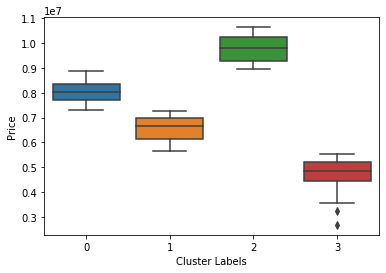

In [540]:
sns.boxplot(data=bg_final_data,x='Cluster Labels',y="Price")
plt.savefig("Price_subclusters.png")

### E.4.6 Visualizing the area ranges in each cluster

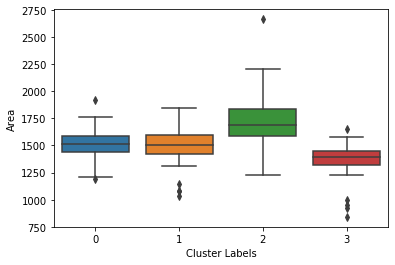

In [541]:
sns.boxplot(data=bg_final_data,x='Cluster Labels',y="Area")
plt.savefig("Area_subclusters.png")

# Section F: Conclusions
## F.1 Sub Clusters Derived
### Below are the sub-clusters formed for the 148 apartments which have a hospital and school in the neighborhood:
**Sub Cluster 0:** Sub Premium Priced 3BHKs (INR 7 Million to 8.5 Million)

**Sub Cluster 1:** Moderately Priced 3BHKs (INR 5.6 Million to 7 Million)

**Sub Cluster 2:** Premium Priced 3BHKs (INR 8.6 Million to 10.3 Million)

**Sub Cluster 3:** Value priced 3 BHKs(INR 2.5 Million to 5.5 Million)


## F.2. Inferences
#### F.2.1 Based on his budget, Surya can make a purchase decision on any of these sub-segments as they are clearly segregated by Price
#### F.2.2 The nearby venues do not seem to have a major impact on the price of the apartments as all of them seem to have a restaurant and cafes. This may lead us to believe that the venues might be coming up because these apartments are there and not vice versa
#### F.2.3 The builders in each of the price subsegments are different. This leads us to believe that the brand plays a large role in the pricing that they command regardless of the area of the apartments.
#### F.2.4 There are other factors such as amenities, location in the city which could be contributing to the pricing of the apartment which can be the subject of a future analysis

